In [1]:
from datetime import datetime
import datetime as dt
import pandas as pd
import numpy as np
import urllib.request, json
import scipy.stats as stats

from metloom.pointdata import MesowestPointData, SnotelPointData
import dataretrieval.nwis as nwis
import pyet
import metpy.calc as calc
from metpy.units import units

import ftplib
import io
import warnings
import datetime as dt
import xarray as xr


# Visualization
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns


## Functions

In [2]:
def calc_net_lw_radiation(temperature, relative_humidity, elevation, dew_pt_temp=None):
    """Compute net longwave clear sky radiation from temperature measurements, relative humidy values and site elevation


    Args:
        temperature (array-like): mean daily temperatures (C)
        relative_humidity (array-like): mean relative humidity (%)
        elevation (float): site elevation (m)
        dew_pt_temp (array-like, optional): Dew point temperature, include if measured. Defaults to None.

    Returns:
        Series: net longwave radiations in W/m2
    """
    SIGMA = 5.67e-8
    CONSTANT = 40

    # Convert temperature to Kelvin
    temperature_K = temperature.to_xarray().squeeze()+273.15
    temperature_K.attrs = {'units':'K'}


    # Using Marks & Dozier, 1979 to calculate emissivity 
    T_prime = temperature_K + (0.0065 * elevation)
    T_prime.attrs = {'units':'K'}
    e_prime = relative_humidity*calc.saturation_vapor_pressure(T_prime)/100
    
    # Hydrostatic pressure
    standard_p = 101325*((293+(elevation*-0.0065))/293)**(-9.81*0.0299/(-.0065*8.314))
    # Emissivity estimate
    epsilon_atmos=(1.24 * (e_prime/T_prime)**(1/7) * (standard_p)/101300)

    # Longwave in estimate
    lw_in = epsilon_atmos * SIGMA * temperature_K**4 - CONSTANT

    # Calculate longwave out
    if dew_pt_temp is None:
        dew_pt_temp = calc.dewpoint_from_relative_humidity(temperature_K,(relative_humidity/100).to_xarray()).values
    lw_out = SIGMA*(dew_pt_temp+273.15)**4

    # Compute net longwave radiation
    rnet = lw_in - lw_out
    return rnet

def normalize_data(df):
    '''Normalized a pandas series'''
    norm = (df - df.mean())/df.std()
    norm.index = norm.index.astype(int)
    return norm

## Precip, max temp, min temp, and snow from 1910-2022

In [342]:
gunnison_df = pd.read_json(r"C:\Users\dlhogan\Downloads\html-to-json-converter.json")

# Fix and convert max temp 
gunnison_df['maxt'] = (gunnison_df['maxt'].replace({'M':np.nan,'-0':'0'}).astype(float) - 32) * 5/9
# Fix and convert min temp

gunnison_df['mint'] = (gunnison_df['mint'].replace({'M':np.nan,'-0':'0'}).astype(float) - 32) * 5/9
# Fix and convert precip
gunnison_df['pcpn'] = gunnison_df['pcpn'].str.replace("A","")
gunnison_df['pcpn'] = gunnison_df['pcpn'].replace({'M':np.nan,'S':np.nan,'T':'0'}).astype(float) * 25.4
# Fix and convert snow
gunnison_df['snow'] = gunnison_df['snow'].str.replace("A","")
gunnison_df['snow'] = gunnison_df['snow'].replace({'M':np.nan,'S':np.nan,'T':'0'}).astype(float) * 25.4

gunnison_df.set_index('gunnison 3 sw', inplace=True)
gunnison_df.index = pd.to_datetime(gunnison_df.index)

winter_gunnison_df = gunnison_df.loc[gunnison_df.index.month < 5 | ((gunnison_df.index.month == 12) & (gunnison_df.index.day > 20)) ]

In [345]:
# winter_gunnison_df['wspd'] = winter_taylor_park_df['WSpd']
# winter_gunnison_df['wspd'] = winter_gunnison_df['wspd'].fillna( winter_taylor_park_df['WSpd'].median())
winter_gunnison_df=winter_gunnison_df.interpolate(method='from_derivatives', order=2)


In [351]:
mean_temp = ((winter_gunnison_df['maxt'] + winter_gunnison_df['mint'])/2).to_xarray() * units("celsius")

rh = 100*calc.relative_humidity_from_dewpoint(temperature=mean_temp, dewpoint=winter_gunnison_df['mint'].to_xarray() * units("celsius")) * units('percent')
net_gunnison_winter = calc_net_lw_radiation(temperature=mean_temp.to_pandas(), 
                      relative_humidity=rh.to_pandas()*1.05,
                      elevation=3000
                        )

# Calculate Penman-Monteith "sublimation"
sublimation_gunnison_pm = pyet.pm(tmean=mean_temp.to_numpy(),
        wind=2.1,#winter_gunnison_df["wspd"],
        rh=rh.to_numpy()*1.05,
        rn=net_gunnison_winter*3600*24/1e6 ,
        elevation=3000)


sublimation_gunnison_pm_df = sublimation_gunnison_pm.to_frame(name='sublimation_mm')
sublimation_gunnison_pm_df['water_year'] =  sublimation_gunnison_pm_df.index.year.where(sublimation_gunnison_pm_df.index.month < 10, sublimation_gunnison_pm_df.index.year + 1)
sublimation_gunnison_totals = sublimation_gunnison_pm_df['sublimation_mm'].groupby(sublimation_gunnison_pm_df['water_year']).sum()
sublimation_gunnison_totals.rename = 'sublimation'

LinregressResult(slope=0.6428791934732038, intercept=18.219794077449507, rvalue=0.7386123824440578, pvalue=6.127334220983144e-07, stderr=0.10372458032440665, intercept_stderr=10.402989280592152)

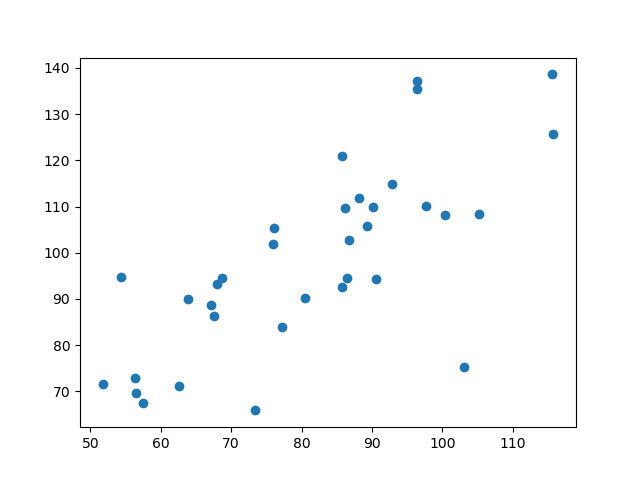

Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 1.0416666269302368, 'type': 'set_device_pixel_ratio'}


In [352]:

%matplotlib widget
plt.scatter(sublimation_gunnison_totals.loc[1988:2021], sublimation_taylor_totals.loc[1988:2021])
stats.linregress(x=sublimation_taylor_totals.loc[:2021], y=sublimation_gunnison_totals.loc[1988:2021])

## Pulls daily data from station in Gunnison 2015-2022

In [4]:
with urllib.request.urlopen("https://coagmet.colostate.edu/data/daily/gun01.json?from=start&to=end&tz=utc&units=m") as url:
    gun01_df = pd.DataFrame(json.loads(url.read().decode()))
gun01_df.columns


Index(['which', 'frequency', 'timestep', 'timezone', 'tzOffset', 'units',
       'station', 'time', 'tAvg', 'tMax', 'tMaxTime', 'tMin', 'tMinTime',
       'rhMax', 'rhMaxTime', 'rhMin', 'rhMinTime', 'solarRad', 'precip',
       'windRun', 'gustSpeed', 'gustTime', 'gustDir', 'etrASCE', 'etrPK',
       'etrHourly', 'etoASCE', 'st5Max', 'st5MaxTime', 'st5Min', 'st5MinTime',
       'st15Max', 'st15MaxTime', 'st15Min', 'st15MinTime'],
      dtype='object')

## Pulls daily met data for Gunnison Airport from 1997-2022

In [82]:
start_year = 1995
end_year = 2022
meso_point = MesowestPointData("KGUC", "GunnisonAirport")
kguc_df = meso_point.get_daily_data(
    datetime(start_year, 1, 1), datetime(end_year, 5, 1),
    [meso_point.ALLOWED_VARIABLES.DEWPOINT,
     meso_point.ALLOWED_VARIABLES.NETLONGWAVE,
     meso_point.ALLOWED_VARIABLES.NETSHORTWAVE,
     meso_point.ALLOWED_VARIABLES.PRESSURE,
     meso_point.ALLOWED_VARIABLES.RH,
     meso_point.ALLOWED_VARIABLES.SNOWDEPTH,
     meso_point.ALLOWED_VARIABLES.SOILTEMP,
     meso_point.ALLOWED_VARIABLES.SOILTEMPIR,
     meso_point.ALLOWED_VARIABLES.SOLARRADIATION,
     meso_point.ALLOWED_VARIABLES.SWE,
     meso_point.ALLOWED_VARIABLES.TEMP,
     meso_point.ALLOWED_VARIABLES.WETBULBTEMPERATURE,
     meso_point.ALLOWED_VARIABLES.WINDDIRECTION,
     meso_point.ALLOWED_VARIABLES.WINDSPEED]
)


Filter to only winter values. 

**Note if pressure values are desired, they are errant for much of this data set**

In [83]:
winter_kguc_df = kguc_df.droplevel(1).loc[kguc_df.droplevel(1).index.month < 5 | ((kguc_df.droplevel(1).index.month == 12) & (kguc_df.droplevel(1).index.day > 1)) ]

Compute net clear sky longwave radiation for Gunnison airport data:

In [84]:
net_kguc_winter = calc_net_lw_radiation(temperature=winter_kguc_df['AIR TEMP'], 
                      relative_humidity=winter_kguc_df['RELATIVE HUMIDITY'],
                      elevation=winter_kguc_df['geometry'].z.unique()[0]/3.28,
                      dew_pt_temp=winter_kguc_df['DEW POINT TEMPERATURE']
                        )

Run the Penman-Monteith method on Gunnison Airport data

In [14]:
# Calculate Penman-Monteith "sublimation"
sublimation_kguc_pm = pyet.pm(tmean=winter_kguc_df['AIR TEMP'],
        wind=winter_kguc_df['WIND SPEED'],
        rh=winter_kguc_df['RELATIVE HUMIDITY'],
        rn=net_kguc_winter*3600*24/1e6 ,
        elevation=winter_kguc_df['geometry'].z.unique()[0]/3.28)


sublimation_kguc_pm_df = sublimation_kguc_pm.to_frame(name='sublimation_mm')
sublimation_kguc_pm_df['water_year'] =  sublimation_kguc_pm_df.index.year.where(sublimation_kguc_pm_df.index.month < 10, sublimation_kguc_pm_df.index.year + 1)
sublimation_kguc_totals = sublimation_kguc_pm_df['sublimation_mm'].groupby(sublimation_kguc_pm_df['water_year']).sum()
sublimation_kguc_totals.rename = 'sublimation'

NameError: name 'winter_kguc_df' is not defined

## Taylor Park Met Data 1988-2021

In [23]:
# Get data and filter appropriately
taylor_park_df = pd.read_csv('data/taylor_park_daily_met.txt',sep='\s+')
taylor_park_elev = 3201
taylor_park_df = taylor_park_df.set_index('Date')
taylor_park_df = taylor_park_df.replace(-9999,np.nan)
taylor_park_df.index = pd.to_datetime(taylor_park_df.index)
taylor_park_df['Year'] =  taylor_park_df.index.year.where(taylor_park_df.index.month < 10, taylor_park_df.index.year + 1)
taylor_park_df = taylor_park_df.rename(columns={'Year':'Water_Yr'})

# Calculated lw net and winterize the data
winter_taylor_park_df = taylor_park_df.loc[taylor_park_df.index.month < 6]
net_taylor_winter = calc_net_lw_radiation(temperature=winter_taylor_park_df['AveT'], 
                      relative_humidity=winter_taylor_park_df['AveRH'],
                      elevation=taylor_park_elev
                        )


In [24]:
sublimation_taylor_pm = pyet.pm(tmean=winter_taylor_park_df['AveT'],
        tmax=winter_taylor_park_df['MaxT'],
        tmin=winter_taylor_park_df['MinT'],
        rhmax=winter_taylor_park_df['MaxRH'],
        rhmin=winter_taylor_park_df['MinRH'],
        wind=winter_taylor_park_df['WSpd'],
        rh=winter_taylor_park_df['AveRH'],
        rn=net_taylor_winter*3600*24/1e6 ,
        elevation=taylor_park_elev)
sublimation_taylor_pm_df = sublimation_taylor_pm.to_frame(name='sublimation_mm')
sublimation_taylor_pm_df['water_year'] =  sublimation_taylor_pm_df.index.year.where(sublimation_taylor_pm_df.index.month < 10, sublimation_taylor_pm_df.index.year + 1)
sublimation_taylor_totals = sublimation_taylor_pm_df['sublimation_mm'].groupby(sublimation_taylor_pm_df['water_year']).sum()
sublimation_taylor_totals.rename = 'sublimation'        

## Get Snotel or Snow Course Data

Compute estimated sublimation at Taylor Park

Pull daily snotel point data from 1991-2022 from Butte snotel station

In [5]:
snotel_point = SnotelPointData("380:CO:SNTL", "MyStation")
butte_df = snotel_point.get_daily_data(
    datetime(1991, 1, 1), datetime(2021, 6, 1),
    [snotel_point.ALLOWED_VARIABLES.PRECIPITATION,
     snotel_point.ALLOWED_VARIABLES.PRECIPITATIONACCUM,
     snotel_point.ALLOWED_VARIABLES.SNOWDEPTH,
     snotel_point.ALLOWED_VARIABLES.SWE,
     snotel_point.ALLOWED_VARIABLES.TEMP]
)
butte_df = butte_df.droplevel(1)

# Add water year
butte_df['water_year'] =  butte_df.index.year.where(butte_df.index.month < 10, butte_df.index.year + 1)

# Get max swe
butte_max_swe_mm = butte_df['SWE'].groupby(butte_df.index.year).max()*25.4

Get Park Cone snotel data starting in 1991

In [6]:
snotel_point = SnotelPointData("680:CO:SNTL", "ParkCone")
park_cone_df = snotel_point.get_daily_data(
    datetime(1991, 1, 1), datetime(2021, 6, 1),
    [snotel_point.ALLOWED_VARIABLES.PRECIPITATION,
     snotel_point.ALLOWED_VARIABLES.PRECIPITATIONACCUM,
     snotel_point.ALLOWED_VARIABLES.SNOWDEPTH,
     snotel_point.ALLOWED_VARIABLES.SWE,
     snotel_point.ALLOWED_VARIABLES.TEMP]
)
park_cone_df = park_cone_df.droplevel(1)

# Get water year for Park Cone data
park_cone_df['water_year'] =  park_cone_df.index.year.where(park_cone_df.index.month < 10, park_cone_df.index.year + 1).astype(int)

# Calculate max swe
park_cone_max_swe_mm = park_cone_df['SWE'].groupby(park_cone_df.index.year).max()*25.4

In [92]:
park_cone_apr1_swe_mm = park_cone_df.loc[(park_cone_df.index.month==4) & (park_cone_df.index.day==1)][['SWE','water_year']]
park_cone_apr1_swe_mm = park_cone_apr1_swe_mm['SWE'].groupby(park_cone_apr1_swe_mm.index.year).mean()*25.4

Get Crested Butte snow course data starting in 1936

In [179]:

snowcourse_point = SnotelPointData("07L01:CO:SNOW", "CrestedButte")
crested_butte_df = snowcourse_point.get_snow_course_data(datetime(1936,2,1),datetime(2021,5,1), [snowcourse_point.ALLOWED_VARIABLES.SWE]).droplevel(1)

# Get water year for Crested Butte data
crested_butte_df['water_year'] =  crested_butte_df.index.year.where(crested_butte_df.index.month < 10, crested_butte_df.index.year + 1).astype(int)

# Calculate max swe (mm)
crested_butte_max_swe_mm = crested_butte_df['SWE'].groupby(crested_butte_df.index.year).max()*25.4

# Fill in missing point with nearby snow course
crested_butte_max_swe_mm[2001]=13.3*25.4
crested_butte_max_swe_mm[2002]=9.0*25.4
crested_butte_max_swe_mm[2003]=15.3*25.4

Could not find timezone info for 07L01:CO:SNOW (CrestedButte)


## Discharge, Peak SWE and Sublimation Relationships
### Results using Butte Snotel and KGUC Sublimation

In [25]:
# USGS stream gaging sites
sites = {'Gunnison River':'09114500', 'East River':'09112200'}

# Normalize annual max swe and sublimation estimates
sntl_max_swe_mm_normalized = normalize_data(butte_max_swe_mm)
spring_sublimation_normalized = normalize_data(sublimation_kguc_totals.loc[:2021])


NameError: name 'sublimation_kguc_totals' is not defined

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, tight_layout=True, figsize=(20,10))
axs = axs.ravel()
residual_df = pd.DataFrame()

# Unchanged values
idx_mask = crested_butte_max_swe_mm.loc[1997:].index
filtered_max_swe = sntl_max_swe_mm_normalized.loc[idx_mask]
x=filtered_max_swe.sort_values()

for i,site in enumerate(sites):
    # Get monthly mean discharge
    monthly_discharge_stats = nwis.get_stats(sites=sites[site], statReportType='monthly', statTypeCd='mean')[0]

    # Compute annual discharge means
    annual_discharge = monthly_discharge_stats['mean_va'].groupby(monthly_discharge_stats['year_nu']).mean()
    annual_discharge_normalized = normalize_data(annual_discharge)

    # Computes spring discharge means
    spring_discharge_stats = monthly_discharge_stats[monthly_discharge_stats['month_nu'].isin([3,4,5,6])]
    spring_discharge = spring_discharge_stats['mean_va'].groupby(spring_discharge_stats['year_nu']).mean()
    spring_discharge_normalized = normalize_data(spring_discharge)

    # Linear regression
    annual_linregress_stats = stats.linregress(x=filtered_max_swe, y=annual_discharge_normalized.loc[idx_mask])
    spring_linregress_stats = stats.linregress(x=filtered_max_swe, y=spring_discharge_normalized.loc[idx_mask])

    # Annual Plots
    y_predicted = annual_linregress_stats[0]*x+annual_linregress_stats[1]
    residual_df[site+'_annual'] = annual_discharge_normalized.loc[idx_mask] - y_predicted
    axs[i].scatter(filtered_max_swe,annual_discharge_normalized.loc[idx_mask], label='Annual Discharge')
    axs[i].plot(x,y_predicted)
    axs[i].set_ylabel('Normalized Annual Discharge')
    axs[i].set_xlabel('Normalized Peak SWE')
    axs[i].set_title(f'Normalized {list(sites.keys())[i]} Discharge vs.\nNormalized Peak SWE - r$^2$={round(annual_linregress_stats[2]**2,2)}')


    # Spring Plots
    y_predicted = spring_linregress_stats[0]*x+spring_linregress_stats[1]
    residual_df[site+'_spring'] = spring_discharge_normalized.loc[idx_mask] - y_predicted
    axs[i+2].scatter(filtered_max_swe,spring_discharge_normalized.loc[idx_mask], label='Spring Discharge')
    axs[i+2].plot(x,y_predicted)
    axs[i+2].set_ylabel('Normalized Spring Discharge')
    axs[i+2].set_xlabel('Normalized Peak SWE')
    axs[i+2].set_title(f'Normalized {list(sites.keys())[i]} Discharge vs.\nNormalized Peak SWE - r$^2$={round(spring_linregress_stats[2]**2,2)}')


fig.suptitle('SWE Data from Butte Snotel', size=18)
fig.savefig('../../figures/butte_sntl_swe_vs_discharge.png')

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, tight_layout=True, figsize=(20,10))
axs = axs.ravel()
cols = residual_df.columns

for i,col in enumerate([0,2]):
    # Linear regression
    # Predictor variable for linear regression
    x1 = spring_sublimation_normalized.loc[residual_df[cols[col]].dropna().index].sort_values()
    x2 = spring_sublimation_normalized.loc[residual_df[cols[col+1]].dropna().index].sort_values()
    annual_linregress_stats = stats.linregress(x=x1, y=residual_df[cols[col]].dropna())
    spring_linregress_stats = stats.linregress(x=x2, y=residual_df[cols[col+1]].dropna())    

    # Annual Plots
    y_predicted = annual_linregress_stats[0]*x1+annual_linregress_stats[1]
    axs[i].scatter(spring_sublimation_normalized.loc[residual_df[cols[col]].index], residual_df[cols[col]])
    axs[i].plot(x1,y_predicted, label=f'R$^2$ = {round(annual_linregress_stats[2]**2,2)}')
    axs[i].set_ylabel('Normalized Discharge(Peak SWE) Residual')
    axs[i].set_xlabel('Normalized Estimated Spring Sublimation')
    axs[i].set_title(f"{cols[col].replace('_',' ').upper()}")
    # axs[i].set_xlim(-2,2)
    # axs[i].set_ylim(-2,2)
    axs[i].legend()

    # Spring Plots
    y_predicted = spring_linregress_stats[0]*x2+spring_linregress_stats[1]
    axs[i+2].scatter(spring_sublimation_normalized.loc[residual_df[cols[col+1]].index], residual_df[cols[col+1]])
    axs[i+2].plot(x2,y_predicted, label=f'R$^2$ = {round(spring_linregress_stats[2]**2,2)}')
    axs[i+2].set_ylabel('Normalized Discharge(Peak SWE) Residual')
    axs[i+2].set_xlabel('Normalized Estimated Spring Sublimation ')
    axs[i+2].set_title(f"{cols[col+1].replace('_',' ').upper()}")
    # axs[i+2].set_xlim(-2,2)
    # axs[i+2].set_ylim(-2,2)
    axs[i+2].legend()

    for j, txt in enumerate(residual_df[cols[i]].index):
        axs[i].annotate(txt, (spring_sublimation_normalized.loc[residual_df[cols[col]].index].iloc[j], residual_df[cols[col]].iloc[j]))
        axs[i+2].annotate(txt, (spring_sublimation_normalized.loc[residual_df[cols[col+1]].index].iloc[j], residual_df[cols[col+1]].iloc[j]))
fig.suptitle('SWE Data from Butte Snotel and Sublimation Estimate from Gunnison Airport', size=18)   
fig.savefig('../../figures/butte_sntl_swe_vs_kguc_sublimation.png')

### Results using Park Cone Snotel and Taylor Park Sublimation (1991-2021)

In [94]:
# USGS stream gaging sites
sites = {'Gunnison River':'09114500', 'East River':'09112500'}

# Normalize annual max swe and sublimation estimates
sntl_max_swe_mm_normalized = normalize_data(park_cone_apr1_swe_mm)
spring_sublimation_normalized = normalize_data(sublimation_taylor_totals.loc[:2021])


Text(0.5, 0.98, 'SWE Data from Park Cone Snotel')

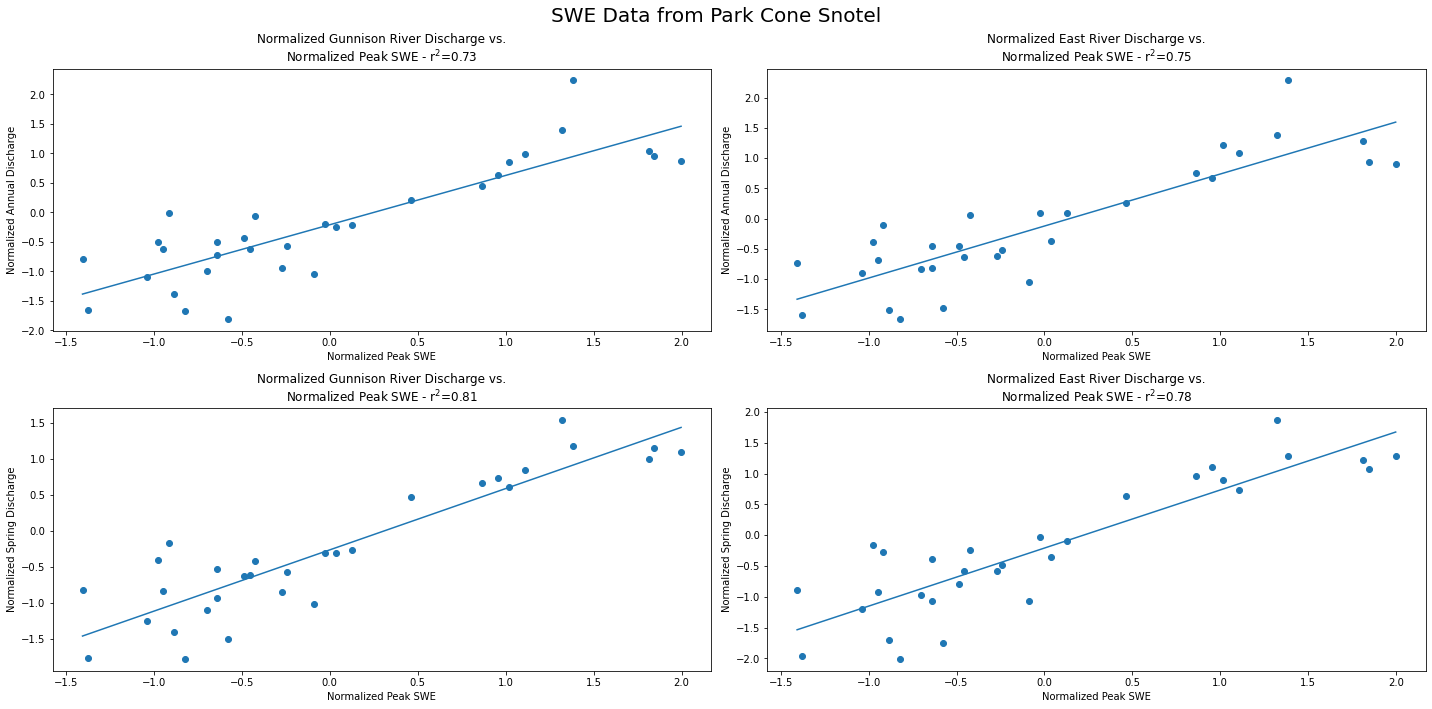

In [95]:
fig, axs = plt.subplots(nrows=2, ncols=2, tight_layout=True, figsize=(20,10))
axs = axs.ravel()
residual_df = pd.DataFrame()

# Unchanged values
idx_mask = sntl_max_swe_mm_normalized.loc[1991:].index
filtered_max_swe = sntl_max_swe_mm_normalized.loc[idx_mask]
x=filtered_max_swe.sort_values()

for i,site in enumerate(sites):
    # Get monthly mean discharge
    monthly_discharge_stats = nwis.get_stats(sites=sites[site], statReportType='monthly', statTypeCd='mean')[0]

    # Compute annual discharge means
    annual_discharge = monthly_discharge_stats['mean_va'].groupby(monthly_discharge_stats['year_nu']).mean()
    annual_discharge_normalized = normalize_data(annual_discharge)

    # Computes spring discharge means
    spring_discharge_stats = monthly_discharge_stats[monthly_discharge_stats['month_nu'].isin([4,5,6])]
    spring_discharge = spring_discharge_stats['mean_va'].groupby(spring_discharge_stats['year_nu']).mean()
    spring_discharge_normalized = normalize_data(spring_discharge)

    # Linear regression
    annual_linregress_stats = stats.linregress(x=filtered_max_swe, y=annual_discharge_normalized.loc[idx_mask])
    spring_linregress_stats = stats.linregress(x=filtered_max_swe, y=spring_discharge_normalized.loc[idx_mask])

    # Annual Plots
    y_predicted = annual_linregress_stats[0]*x+annual_linregress_stats[1]
    residual_df[site+'_annual'] = annual_discharge_normalized.loc[idx_mask] - y_predicted
    axs[i].scatter(filtered_max_swe,annual_discharge_normalized.loc[idx_mask], label='Annual Discharge')
    axs[i].plot(x,y_predicted)
    axs[i].set_ylabel('Normalized Annual Discharge')
    axs[i].set_xlabel('Normalized Peak SWE')
    axs[i].set_title(f'Normalized {list(sites.keys())[i]} Discharge vs.\nNormalized Peak SWE - r$^2$={round(annual_linregress_stats[2]**2,2)}')


    # Spring Plots
    y_predicted = spring_linregress_stats[0]*x+spring_linregress_stats[1]
    residual_df[site+'_spring'] = spring_discharge_normalized.loc[idx_mask] - y_predicted
    axs[i+2].scatter(filtered_max_swe,spring_discharge_normalized.loc[idx_mask], label='Spring Discharge')
    axs[i+2].plot(x,y_predicted)
    axs[i+2].set_ylabel('Normalized Spring Discharge')
    axs[i+2].set_xlabel('Normalized Peak SWE')
    axs[i+2].set_title(f'Normalized {list(sites.keys())[i]} Discharge vs.\nNormalized Peak SWE - r$^2$={round(spring_linregress_stats[2]**2,2)}')

fig.suptitle('SWE Data from Park Cone Snotel', size=20)
# fig.savefig('../../figures/park_cone_sntl_vs_discharge.png')


Text(0.5, 0.98, 'SWE Data from Park Cone Snotel and Sublimation Estimate from Taylor Park')

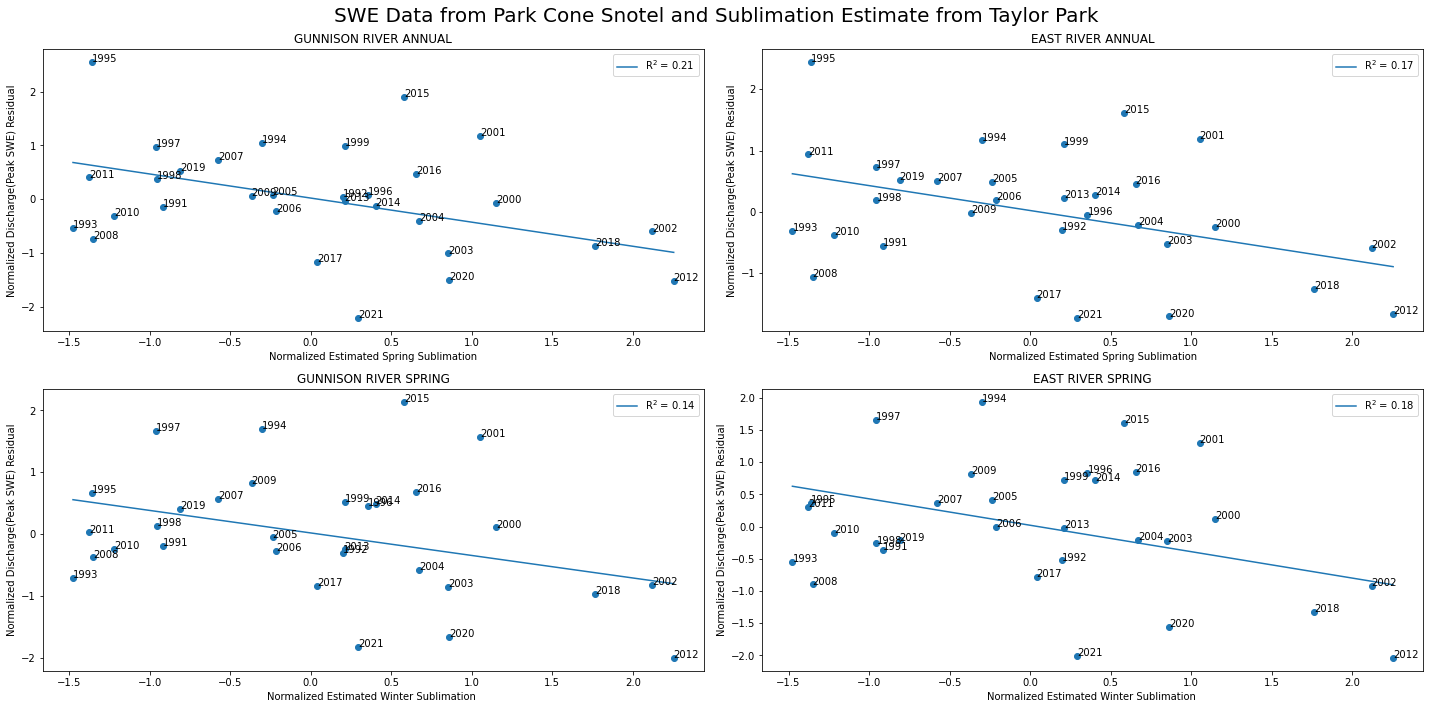

In [96]:
fig, axs = plt.subplots(nrows=2, ncols=2, tight_layout=True, figsize=(20,10))
axs = axs.ravel()
cols = residual_df.columns

for i,col in enumerate([0,2]):
    # Linear regression
    # Predictor variable for linear regression
    x1 = spring_sublimation_normalized.loc[residual_df[cols[col]].dropna().index].sort_values()
    x2 = spring_sublimation_normalized.loc[residual_df[cols[col+1]].dropna().index].sort_values()
    annual_linregress_stats = stats.linregress(x=x1, y=normalize_data(residual_df[cols[col]]).dropna())
    spring_linregress_stats = stats.linregress(x=x2, y=normalize_data(residual_df[cols[col+1]]).dropna())    

    # Annual Plots
    y_predicted = annual_linregress_stats[0]*x1+annual_linregress_stats[1]
    axs[i].scatter(spring_sublimation_normalized.loc[residual_df[cols[col]].index], normalize_data(residual_df[cols[col]]))
    axs[i].plot(x1,y_predicted, label=f'R$^2$ = {round(annual_linregress_stats[2]**2,2)}')
    axs[i].set_ylabel('Normalized Discharge(Peak SWE) Residual')
    axs[i].set_xlabel('Normalized Estimated Spring Sublimation')
    axs[i].set_title(f"{cols[col].replace('_',' ').upper()}")
    axs[i].legend()

    # Spring Plots
    y_predicted = spring_linregress_stats[0]*x2+spring_linregress_stats[1]
    axs[i+2].scatter(spring_sublimation_normalized.loc[residual_df[cols[col+1]].index], normalize_data(residual_df[cols[col+1]]))
    axs[i+2].plot(x2,y_predicted, label=f'R$^2$ = {round(spring_linregress_stats[2]**2,2)}')
    axs[i+2].set_ylabel('Normalized Discharge(Peak SWE) Residual')
    axs[i+2].set_xlabel('Normalized Estimated Winter Sublimation ')
    axs[i+2].set_title(f"{cols[col+1].replace('_',' ').upper()}")
    axs[i+2].legend()

    for j, txt in enumerate(residual_df[cols[i]].index):
        axs[i].annotate(txt, (spring_sublimation_normalized.loc[residual_df[cols[col]].index].iloc[j], normalize_data(residual_df[cols[col]]).iloc[j]))
        axs[i+2].annotate(txt, (spring_sublimation_normalized.loc[residual_df[cols[col+1]].index].iloc[j], normalize_data(residual_df[cols[col+1]]).iloc[j]))
fig.suptitle('SWE Data from Park Cone Snotel and Sublimation Estimate from Taylor Park', size=20)  
# fig.savefig('../../figures/park_cone_sntl_vs_taylor_sublimation.png')

### Results using Crested Butte snow course and Taylor Park Sublimation (1988-2021)

In [247]:
# USGS stream gaging sites
sites = {'Gunnison River':'09114500', 'East River':'09112500'}

# Normalize annual max swe and sublimation estimates
sntl_max_swe_mm_normalized = normalize_data(crested_butte_max_swe_mm)
spring_sublimation_normalized = normalize_data(sublimation_taylor_totals.loc[:2021])


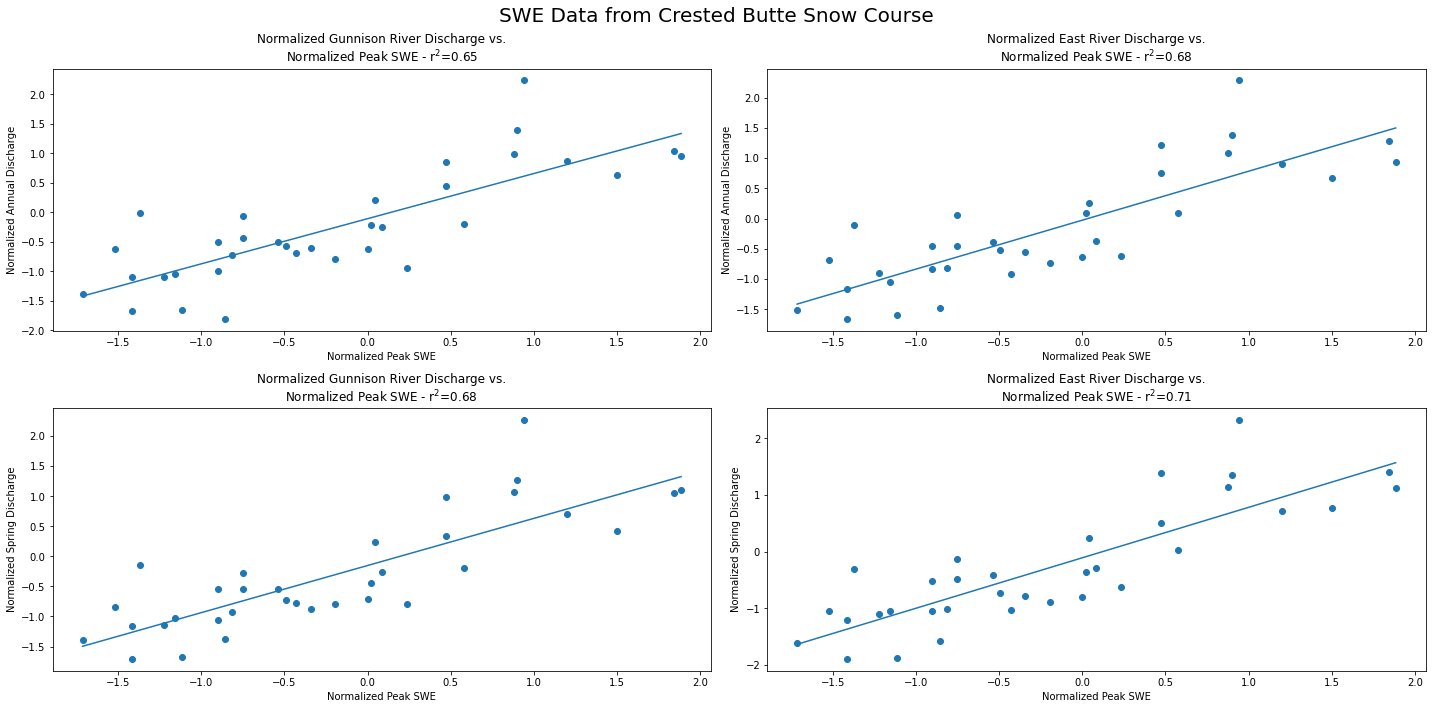

In [251]:
fig, axs = plt.subplots(nrows=2, ncols=2, tight_layout=True, figsize=(20,10))
axs = axs.ravel()
residual_df = pd.DataFrame()

# Unchanged values
idx_mask = crested_butte_max_swe_mm.loc[1988:].index
filtered_max_swe = sntl_max_swe_mm_normalized.loc[idx_mask]
x=filtered_max_swe.sort_values()

for i,site in enumerate(sites):
    # Get monthly mean discharge
    monthly_discharge_stats = nwis.get_stats(sites=sites[site], statReportType='monthly', statTypeCd='mean')[0]

    # Compute annual discharge means
    annual_discharge = monthly_discharge_stats['mean_va'].groupby(monthly_discharge_stats['year_nu']).mean()
    annual_discharge_normalized = normalize_data(annual_discharge)

    # Computes spring discharge means
    spring_discharge_stats = monthly_discharge_stats[monthly_discharge_stats['month_nu'].isin([5,6,7])]
    spring_discharge = spring_discharge_stats['mean_va'].groupby(spring_discharge_stats['year_nu']).mean()
    spring_discharge_normalized = normalize_data(spring_discharge)

    # Linear regression
    annual_linregress_stats = stats.linregress(x=filtered_max_swe, y=annual_discharge_normalized.loc[idx_mask])
    spring_linregress_stats = stats.linregress(x=filtered_max_swe, y=spring_discharge_normalized.loc[idx_mask])

    # Annual Plots
    y_predicted = annual_linregress_stats[0]*x+annual_linregress_stats[1]
    residual_df[site+'_annual'] = annual_discharge_normalized.loc[idx_mask] - y_predicted
    axs[i].scatter(filtered_max_swe,annual_discharge_normalized.loc[idx_mask], label='Annual Discharge')
    axs[i].plot(x,y_predicted)
    axs[i].set_ylabel('Normalized Annual Discharge')
    axs[i].set_xlabel('Normalized Peak SWE')
    axs[i].set_title(f'Normalized {list(sites.keys())[i]} Discharge vs.\nNormalized Peak SWE - r$^2$={round(annual_linregress_stats[2]**2,2)}')


    # Spring Plots
    y_predicted = spring_linregress_stats[0]*x+spring_linregress_stats[1]
    residual_df[site+'_spring'] = spring_discharge_normalized.loc[idx_mask] - y_predicted
    axs[i+2].scatter(filtered_max_swe,spring_discharge_normalized.loc[idx_mask], label='Spring Discharge')
    axs[i+2].plot(x,y_predicted)
    axs[i+2].set_ylabel('Normalized Spring Discharge')
    axs[i+2].set_xlabel('Normalized Peak SWE')
    axs[i+2].set_title(f'Normalized {list(sites.keys())[i]} Discharge vs.\nNormalized Peak SWE - r$^2$={round(spring_linregress_stats[2]**2,2)}')


fig.suptitle('SWE Data from Crested Butte Snow Course', size=20)
fig.savefig('../../figures/crested_butte_snowcourse_swe_vs_discharge.png')

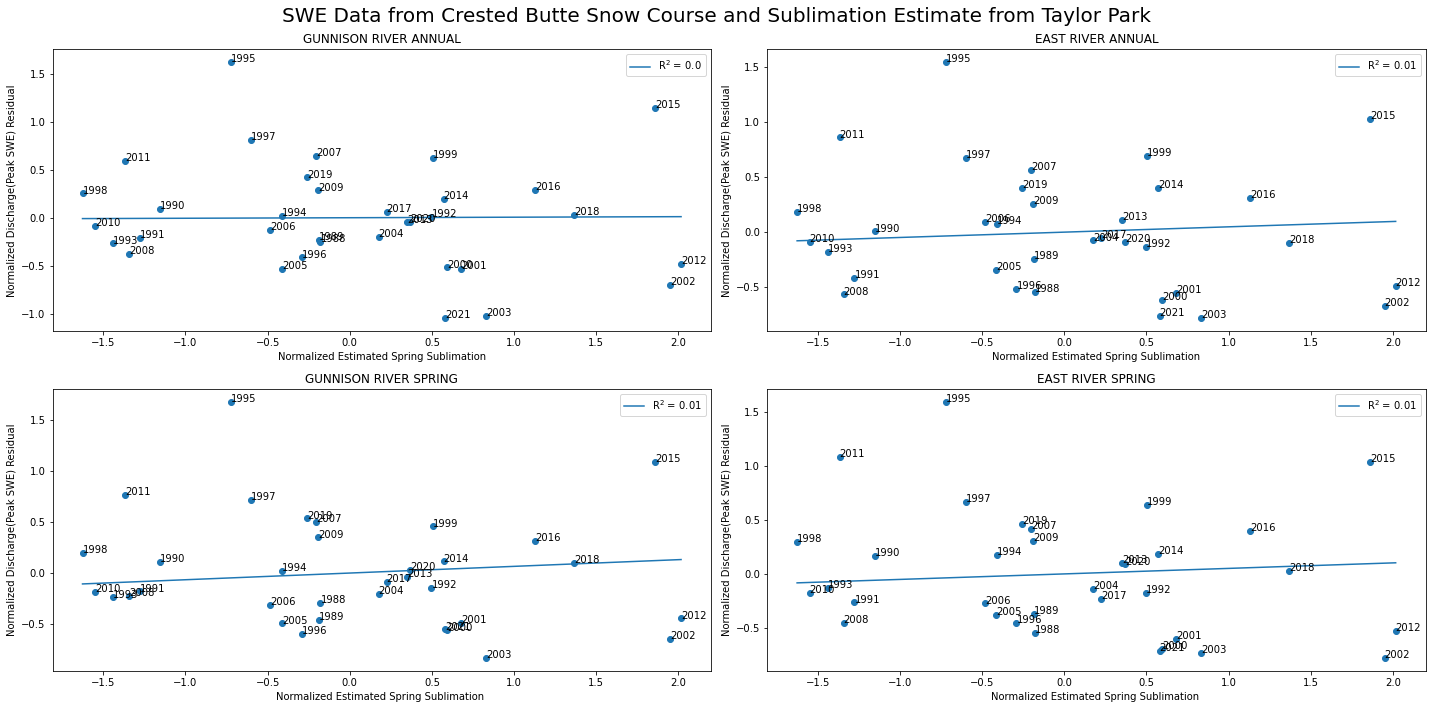

In [252]:
fig, axs = plt.subplots(nrows=2, ncols=2, tight_layout=True, figsize=(20,10))
axs = axs.ravel()
cols = residual_df.columns

for i,col in enumerate([0,2]):
    # Linear regression
    # Predictor variable for linear regression
    x1 = spring_sublimation_normalized.loc[residual_df[cols[col]].dropna().index].sort_values()
    x2 = spring_sublimation_normalized.loc[residual_df[cols[col+1]].dropna().index].sort_values()
    annual_linregress_stats = stats.linregress(x=x1, y=residual_df[cols[col]].dropna())
    spring_linregress_stats = stats.linregress(x=x2, y=residual_df[cols[col+1]].dropna())    

    # Annual Plots
    y_predicted = annual_linregress_stats[0]*x1+annual_linregress_stats[1]
    axs[i].scatter(spring_sublimation_normalized.loc[residual_df[cols[col]].index], residual_df[cols[col]])
    axs[i].plot(x1,y_predicted, label=f'R$^2$ = {round(annual_linregress_stats[2]**2,2)}')
    axs[i].set_ylabel('Normalized Discharge(Peak SWE) Residual')
    axs[i].set_xlabel('Normalized Estimated Spring Sublimation')
    axs[i].set_title(f"{cols[col].replace('_',' ').upper()}")
    axs[i].legend()

    # Spring Plots
    y_predicted = spring_linregress_stats[0]*x2+spring_linregress_stats[1]
    axs[i+2].scatter(spring_sublimation_normalized.loc[residual_df[cols[col+1]].index], residual_df[cols[col+1]])
    axs[i+2].plot(x2,y_predicted, label=f'R$^2$ = {round(spring_linregress_stats[2]**2,2)}')
    axs[i+2].set_ylabel('Normalized Discharge(Peak SWE) Residual')
    axs[i+2].set_xlabel('Normalized Estimated Spring Sublimation ')
    axs[i+2].set_title(f"{cols[col+1].replace('_',' ').upper()}")
    axs[i+2].legend()

    for j, txt in enumerate(residual_df[cols[i]].index):
        axs[i].annotate(txt, (spring_sublimation_normalized.loc[residual_df[cols[col]].index].iloc[j], residual_df[cols[col]].iloc[j]))
        axs[i+2].annotate(txt, (spring_sublimation_normalized.loc[residual_df[cols[col+1]].index].iloc[j], residual_df[cols[col+1]].iloc[j]))

fig.suptitle('SWE Data from Crested Butte Snow Course and Sublimation Estimate from Taylor Park', size=20)
fig.savefig('../../figures/crested_butte_snowcourse_swe_vs_taylor_sublimation.png')

### Results using Crested Butte snow course and Gunnison Sublimation (1997-2021)

In [23]:
# USGS stream gaging sites
sites = {'Gunnison River':'09114500', 'East River':'09112500'}

# Normalize annual max swe and sublimation estimates
sntl_max_swe_mm_normalized = normalize_data(crested_butte_max_swe_mm)
spring_sublimation_normalized = normalize_data(sublimation_kguc_totals.loc[:2021])


Text(0.5, 0.98, 'SWE Data from Crested Butte Snow Course')

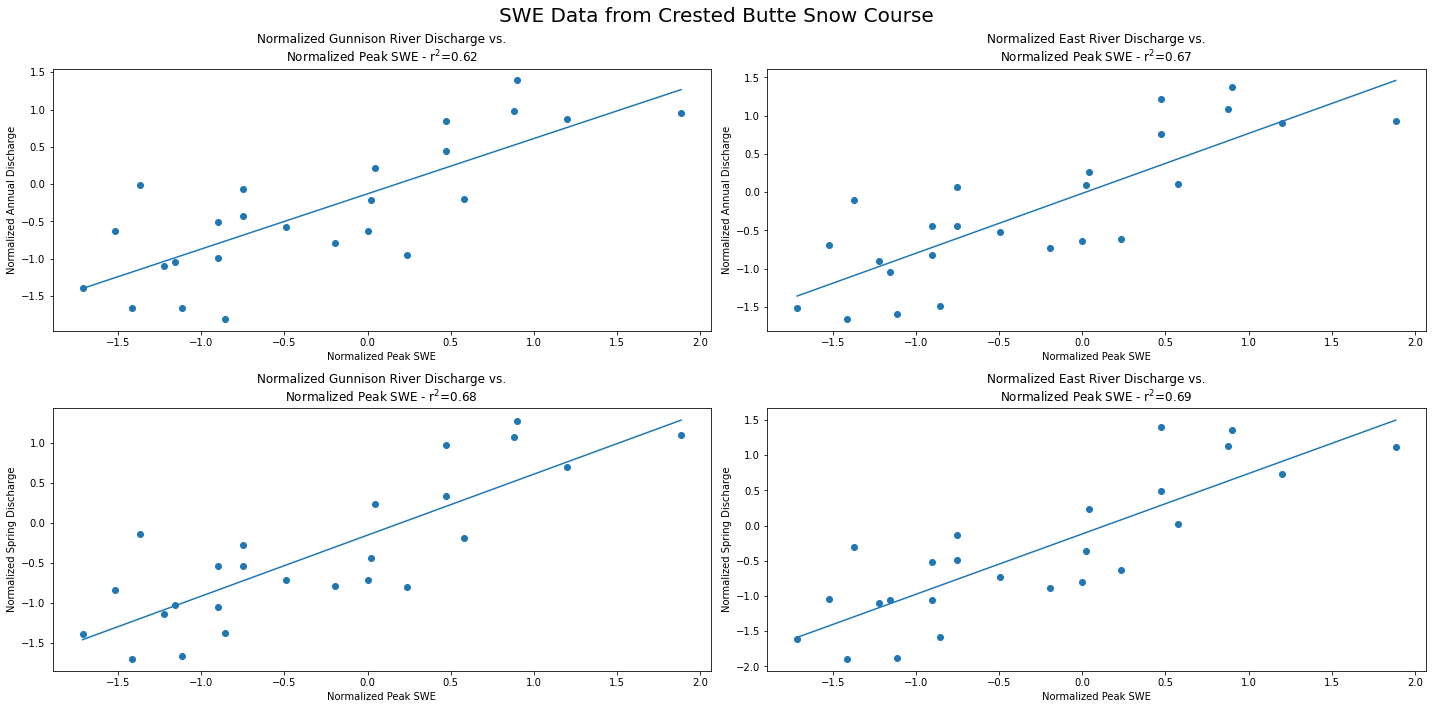

In [256]:
fig, axs = plt.subplots(nrows=2, ncols=2, tight_layout=True, figsize=(20,10))
axs = axs.ravel()
residual_df = pd.DataFrame()

# Unchanged values
idx_mask = crested_butte_max_swe_mm.loc[1997:].index
filtered_max_swe = sntl_max_swe_mm_normalized.loc[idx_mask]
x=filtered_max_swe.sort_values()

for i,site in enumerate(sites):
    # Get monthly mean discharge
    monthly_discharge_stats = nwis.get_stats(sites=sites[site], statReportType='monthly', statTypeCd='mean')[0]

    # Compute annual discharge means
    annual_discharge = monthly_discharge_stats['mean_va'].groupby(monthly_discharge_stats['year_nu']).mean()
    annual_discharge_normalized = normalize_data(annual_discharge)

    # Computes spring discharge means
    spring_discharge_stats = monthly_discharge_stats[monthly_discharge_stats['month_nu'].isin([5,6,7])]
    spring_discharge = spring_discharge_stats['mean_va'].groupby(spring_discharge_stats['year_nu']).mean()
    spring_discharge_normalized = normalize_data(spring_discharge)

    # Linear regression
    annual_linregress_stats = stats.linregress(x=filtered_max_swe, y=annual_discharge_normalized.loc[idx_mask])
    spring_linregress_stats = stats.linregress(x=filtered_max_swe, y=spring_discharge_normalized.loc[idx_mask])

    # Annual Plots
    y_predicted = annual_linregress_stats[0]*x+annual_linregress_stats[1]
    residual_df[site+'_annual'] = annual_discharge_normalized.loc[idx_mask] - y_predicted
    axs[i].scatter(filtered_max_swe,annual_discharge_normalized.loc[idx_mask], label='Annual Discharge')
    axs[i].plot(x,y_predicted)
    axs[i].set_ylabel('Normalized Annual Discharge')
    axs[i].set_xlabel('Normalized Peak SWE')
    axs[i].set_title(f'Normalized {list(sites.keys())[i]} Discharge vs.\nNormalized Peak SWE - r$^2$={round(annual_linregress_stats[2]**2,2)}')


    # Spring Plots
    y_predicted = spring_linregress_stats[0]*x+spring_linregress_stats[1]
    residual_df[site+'_spring'] = spring_discharge_normalized.loc[idx_mask] - y_predicted
    axs[i+2].scatter(filtered_max_swe,spring_discharge_normalized.loc[idx_mask], label='Spring Discharge')
    axs[i+2].plot(x,y_predicted)
    axs[i+2].set_ylabel('Normalized Spring Discharge')
    axs[i+2].set_xlabel('Normalized Peak SWE')
    axs[i+2].set_title(f'Normalized {list(sites.keys())[i]} Discharge vs.\nNormalized Peak SWE - r$^2$={round(spring_linregress_stats[2]**2,2)}')

fig.suptitle('SWE Data from Crested Butte Snow Course', size=20)


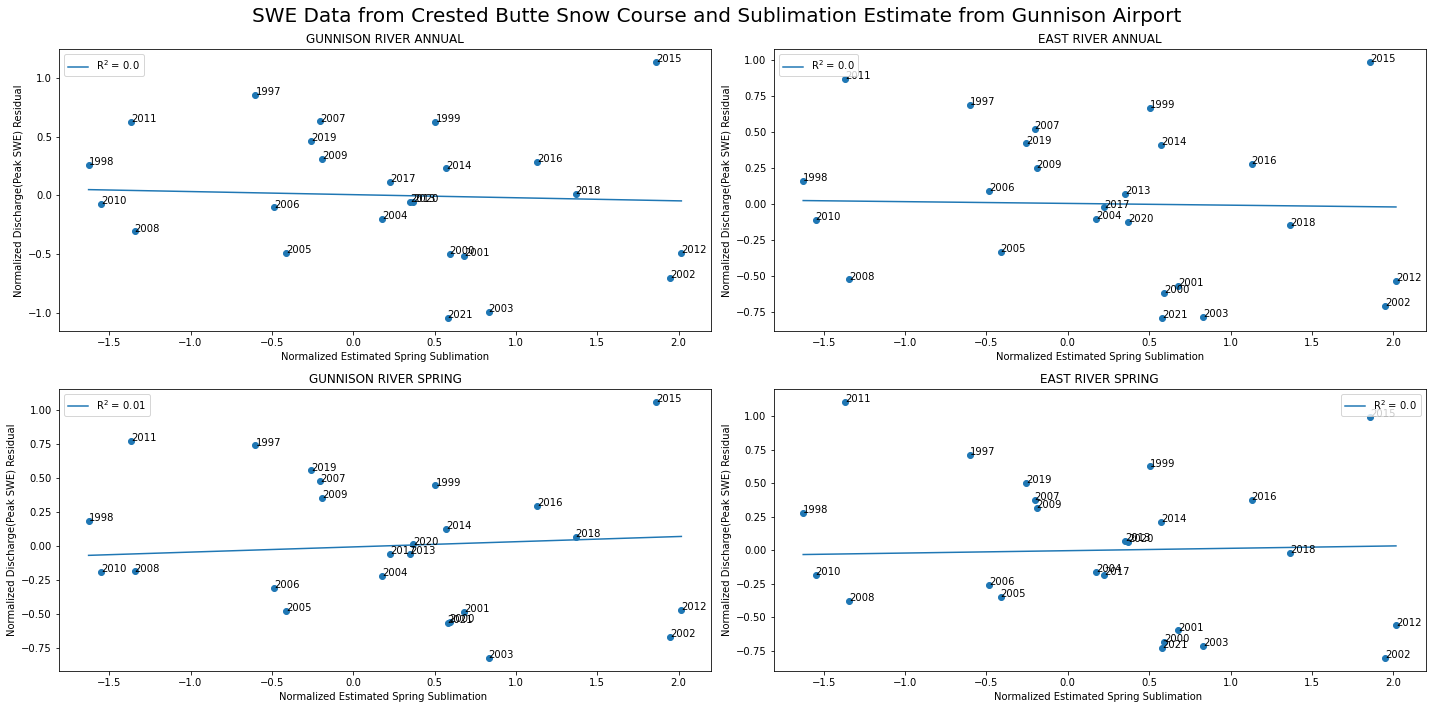

In [257]:
fig, axs = plt.subplots(nrows=2, ncols=2, tight_layout=True, figsize=(20,10))
axs = axs.ravel()
cols = residual_df.columns

for i,col in enumerate([0,2]):
    # Linear regression
    # Predictor variable for linear regression
    x1 = spring_sublimation_normalized.loc[residual_df[cols[col]].dropna().index].sort_values()
    x2 = spring_sublimation_normalized.loc[residual_df[cols[col+1]].dropna().index].sort_values()
    annual_linregress_stats = stats.linregress(x=x1, y=residual_df[cols[col]].dropna())
    spring_linregress_stats = stats.linregress(x=x2, y=residual_df[cols[col+1]].dropna())    

    # Annual Plots
    y_predicted = annual_linregress_stats[0]*x1+annual_linregress_stats[1]
    axs[i].scatter(spring_sublimation_normalized.loc[residual_df[cols[col]].index], residual_df[cols[col]])
    axs[i].plot(x1,y_predicted, label=f'R$^2$ = {round(annual_linregress_stats[2]**2,2)}')
    axs[i].set_ylabel('Normalized Discharge(Peak SWE) Residual')
    axs[i].set_xlabel('Normalized Estimated Spring Sublimation')
    axs[i].set_title(f"{cols[col].replace('_',' ').upper()}")
    axs[i].legend()

    # Spring Plots
    y_predicted = spring_linregress_stats[0]*x2+spring_linregress_stats[1]
    axs[i+2].scatter(spring_sublimation_normalized.loc[residual_df[cols[col+1]].index], residual_df[cols[col+1]])
    axs[i+2].plot(x2,y_predicted, label=f'R$^2$ = {round(spring_linregress_stats[2]**2,2)}')
    axs[i+2].set_ylabel('Normalized Discharge(Peak SWE) Residual')
    axs[i+2].set_xlabel('Normalized Estimated Spring Sublimation ')
    axs[i+2].set_title(f"{cols[col+1].replace('_',' ').upper()}")
    axs[i+2].legend()

    for j, txt in enumerate(residual_df[cols[i]].index):
        axs[i].annotate(txt, (spring_sublimation_normalized.loc[residual_df[cols[col]].index].iloc[j], residual_df[cols[col]].iloc[j]))
        axs[i+2].annotate(txt, (spring_sublimation_normalized.loc[residual_df[cols[col+1]].index].iloc[j], residual_df[cols[col+1]].iloc[j]))

fig.suptitle('SWE Data from Crested Butte Snow Course and Sublimation Estimate from Gunnison Airport', size=20)
fig.savefig('../../figures/crested_butte_snowcourse_swe_vs_kguc_sublimation.png')

(-2.5, 2.5)

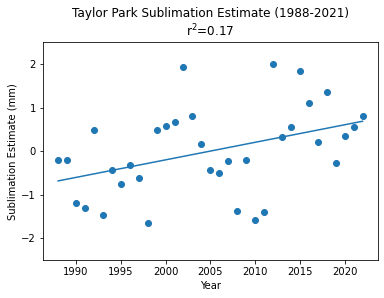

In [215]:
plt.scatter(sublimation_taylor_totals.index,normalize_data(sublimation_taylor_totals))

linregress_stats = stats.linregress(sublimation_taylor_totals.index,normalize_data(sublimation_taylor_totals))
plt.plot(sublimation_taylor_totals.index, linregress_stats[0]*sublimation_taylor_totals.index+linregress_stats[1])
plt.xlabel('Year')
plt.ylabel('Sublimation Estimate (mm)')
plt.title(f'Taylor Park Sublimation Estimate (1988-2021)\nr$^2$={round(linregress_stats[2]**2,2)}')
plt.ylim(-2.5,2.5)

In [35]:
residual_df = pd.DataFrame()
# USGS stream gaging sites
sites = {'Taylor River':'09110000','Gunnison River':'09114500', 'East River':'09112500'}

# Normalize annual max swe and sublimation estimates
sntl_max_swe_mm_normalized = normalize_data(crested_butte_max_swe_mm)

# Unchanged values
idx_mask = crested_butte_max_swe_mm.loc[1945:].index
filtered_max_swe = sntl_max_swe_mm_normalized.loc[idx_mask]
x=filtered_max_swe.sort_values()

for i,site in enumerate(sites):
    # Get monthly mean discharge
    monthly_discharge_stats = nwis.get_stats(sites=sites[site], statReportType='monthly', statTypeCd='mean')[0]

    # Compute annual discharge means
    annual_discharge = monthly_discharge_stats['mean_va'].groupby(monthly_discharge_stats['year_nu']).mean()
    annual_discharge_normalized = normalize_data(annual_discharge)

    # # Computes spring discharge means
    # spring_discharge_stats = monthly_discharge_stats[monthly_discharge_stats['month_nu'].isin([5,6,7])]
    # spring_discharge = spring_discharge_stats['mean_va'].groupby(spring_discharge_stats['year_nu']).mean()
    # spring_discharge_normalized = normalize_data(spring_discharge)

    # Linear regression
    annual_linregress_stats = stats.linregress(x=filtered_max_swe, y=annual_discharge_normalized.loc[idx_mask])
    # spring_linregress_stats = stats.linregress(x=filtered_max_swe, y=spring_discharge_normalized.loc[idx_mask])

    # Annual Plots
    y_predicted = annual_linregress_stats[0]*x+annual_linregress_stats[1]
    residual_df[site+'_annual'] = annual_discharge_normalized.loc[idx_mask] - y_predicted

    # Spring Plots
    # y_predicted = spring_linregress_stats[0]*x+spring_linregress_stats[1]
    # residual_df[site+'_spring'] = spring_discharge_normalized.loc[idx_mask] - y_predicted


<AxesSubplot:xlabel='datetime'>

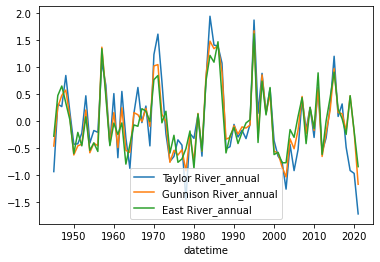

In [36]:
residual_df.plot()

# Next I want to check this against the 2009-2021 billy barr dataset so see how well it performs for some of the areas rivers.

In [88]:
filepath = r"C:\Users\dlhogan\OneDrive - UW\Documents\Coursework\UW-21-22\Q2-spring-quarter-2022\mtn-hydro\Scripts\billy-barr-all.dat"
bb_data = pd.read_table(filepath, delimiter=',', header=1).dropna()
units = bb_data.loc[0].to_list()
bb_data = bb_data.loc[1:]
col_renames = [col.replace(' ','') for col in bb_data.columns]
bb_data = bb_data.rename(columns=dict(zip(bb_data.columns,col_renames)))

C:\Users\dlhogan\AppData\Local\Temp\ipykernel_10564\2800660841.py:2: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77) have mixed types. Specify dtype option on import or set low_memory=False.
  bb_data = pd.read_table(filepath, delimiter=',', header=1).dropna()


In [98]:
bb_data['Datetime'] = pd.to_datetime(bb_data['Date']+' '+bb_data['Time'], format='%Y%m%d %H:%M')
bb_data = bb_data.set_index('Datetime')
bb_data_ma = bb_data[~bb_data.isin(['M',-9999.])]

In [ ]:
bb_daily_ma = bb_data_ma.groupby(bb_data_ma.index.date).mean()
bb_daily_ma.index = pd.to_datetime(bb_daily_ma.index)

In [124]:
bb_daily_ma.index = pd.to_datetime(bb_daily_ma.index)

,Date,Time,Solar,,Stddev,.1,Wind,.2,Wind,.3,...,MaxBat,.33,MinBat,.34,Battery,.35,DatPan,.36,Station,.37
Datetime,,,,,,,,,,,,,,,,,,,,,
2015-09-01 00:00:00,2015/09/01,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.12,0.0,13.02,NaN,13.1,NaN,37.93,NaN,505,NaN
2015-09-01 00:10:00,2015/09/01,00:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.1,0.0,13.06,NaN,13.09,NaN,37.66,NaN,505,NaN
2015-09-01 00:20:00,2015/09/01,00:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.09,0.0,13.0,NaN,13.07,NaN,37.41,NaN,505,NaN
2015-09-01 00:30:00,2015/09/01,00:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.08,0.0,13.04,NaN,13.07,NaN,37.24,NaN,505,NaN
2015-09-01 00:40:00,2015/09/01,00:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.07,0.0,12.98,NaN,13.04,NaN,37.1,NaN,505,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-01 13:00:00,2022/02/01,13:00,22.53,0,1.032,0,1.439,0,1.359,0,...,14.43,0,14.36,0,14.39,0,31.7,0,505,0
2022-02-01 13:10:00,2022/02/01,13:10,20.21,0,0.6881,0,2.245,0,2.159,0,...,14.46,0,14.36,0,14.41,0,31.81,0,505,0
2022-02-01 13:20:00,2022/02/01,13:20,19.44,0,1.376,0,1.79,0,1.774,0,...,14.45,0,14.23,0,14.42,0,31.58,0,505,0


In [141]:
# Calculated lw net and winterize the data
winter_bb_data = bb_daily_ma.loc[bb_daily_ma.index.month < 5 | ((bb_daily_ma.index.month == 12) & (bb_daily_ma.index.day > 1)) ]
net_bb_winter = calc_net_lw_radiation(temperature=(5/9)*(winter_bb_data['AvAir'].astype(float)-32), 
                      relative_humidity=winter_bb_data['Rel'].astype(float),
                      elevation=2890
                        )


In [151]:
cols = []
count = 1
for column in winter_bb_data.columns:
    if column == 'Wind':
        cols.append(f'Wind_{count}')
        count+=1
        continue
    cols.append(column)
winter_bb_data.columns = cols

In [153]:
sublimation_bb_pm = pyet.pm(tmean=(5/9)*(winter_bb_data['AvAir'].astype(float)-32),
        tmax=(winter_bb_data['MxAir'].astype(float)-32)*(5/9),
        tmin=(winter_bb_data['MnAir'].astype(float)-32)*(5/9),
        rhmax=winter_bb_data['MxRel'].astype(float),
        rhmin=winter_bb_data['MnRel'].astype(float),
        wind=winter_bb_data['Wind_1'].astype(float),
        rh=winter_bb_data['Rel'].astype(float),
        rn=net_bb_winter*3600*24/1e6 ,
        elevation=2890)
sublimation_bb_pm_df = sublimation_bb_pm.to_frame(name='sublimation_mm')
sublimation_bb_pm_df['water_year'] =  sublimation_bb_pm_df.index.year.where(sublimation_bb_pm_df.index.month < 10, sublimation_bb_pm_df.index.year + 1)
sublimation_bb_totals = sublimation_bb_pm_df['sublimation_mm'].groupby(sublimation_bb_pm_df['water_year']).sum()
sublimation_bb_totals.rename = 'sublimation'     


In [259]:
# USGS stream gaging sites
sites = {'Gunnison River':'09114500', 'East River':'09112500'}

# Normalize annual max swe and sublimation estimates
sntl_max_swe_mm_normalized = normalize_data(butte_max_swe_mm).loc[2016:2021]
spring_sublimation_normalized = normalize_data(sublimation_bb_totals.loc[:2021])


Text(0.5, 0.98, 'SWE Data from Crested Butte Snow Course')

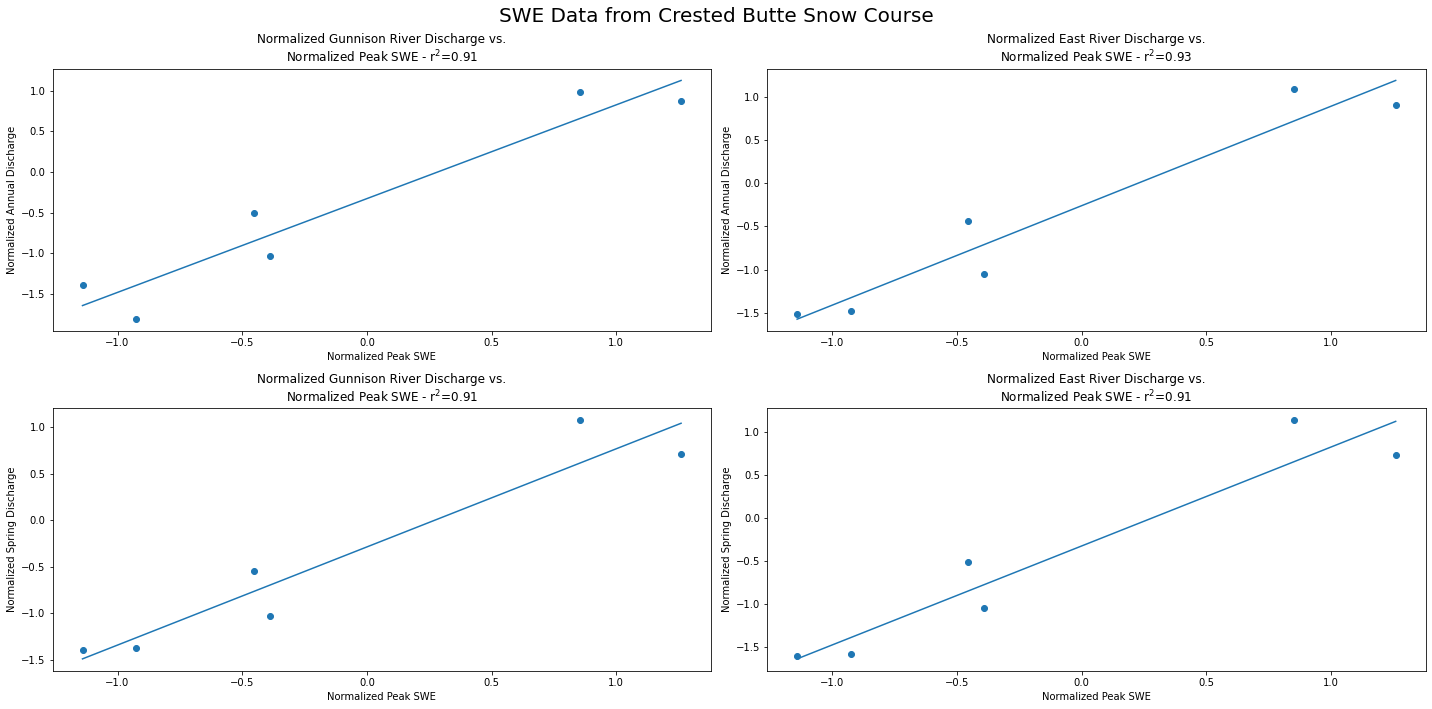

In [260]:
fig, axs = plt.subplots(nrows=2, ncols=2, tight_layout=True, figsize=(20,10))
axs = axs.ravel()
residual_df = pd.DataFrame()

# Unchanged values
idx_mask = sntl_max_swe_mm_normalized.index
filtered_max_swe = sntl_max_swe_mm_normalized
x=filtered_max_swe.sort_values()

for i,site in enumerate(sites):
    # Get monthly mean discharge
    monthly_discharge_stats = nwis.get_stats(sites=sites[site], statReportType='monthly', statTypeCd='mean')[0]

    # Compute annual discharge means
    annual_discharge = monthly_discharge_stats['mean_va'].groupby(monthly_discharge_stats['year_nu']).mean()
    annual_discharge_normalized = normalize_data(annual_discharge)

    # Computes spring discharge means
    spring_discharge_stats = monthly_discharge_stats[monthly_discharge_stats['month_nu'].isin([5,6,7])]
    spring_discharge = spring_discharge_stats['mean_va'].groupby(spring_discharge_stats['year_nu']).mean()
    spring_discharge_normalized = normalize_data(spring_discharge)

    # Linear regression
    annual_linregress_stats = stats.linregress(x=filtered_max_swe, y=annual_discharge_normalized.loc[idx_mask])
    spring_linregress_stats = stats.linregress(x=filtered_max_swe, y=spring_discharge_normalized.loc[idx_mask])

    # Annual Plots
    y_predicted = annual_linregress_stats[0]*x+annual_linregress_stats[1]
    residual_df[site+'_annual'] = annual_discharge_normalized.loc[idx_mask] - y_predicted
    axs[i].scatter(filtered_max_swe,annual_discharge_normalized.loc[idx_mask], label='Annual Discharge')
    axs[i].plot(x,y_predicted)
    axs[i].set_ylabel('Normalized Annual Discharge')
    axs[i].set_xlabel('Normalized Peak SWE')
    axs[i].set_title(f'Normalized {list(sites.keys())[i]} Discharge vs.\nNormalized Peak SWE - r$^2$={round(annual_linregress_stats[2]**2,2)}')


    # Spring Plots
    y_predicted = spring_linregress_stats[0]*x+spring_linregress_stats[1]
    residual_df[site+'_spring'] = spring_discharge_normalized.loc[idx_mask] - y_predicted
    axs[i+2].scatter(filtered_max_swe,spring_discharge_normalized.loc[idx_mask], label='Spring Discharge')
    axs[i+2].plot(x,y_predicted)
    axs[i+2].set_ylabel('Normalized Spring Discharge')
    axs[i+2].set_xlabel('Normalized Peak SWE')
    axs[i+2].set_title(f'Normalized {list(sites.keys())[i]} Discharge vs.\nNormalized Peak SWE - r$^2$={round(spring_linregress_stats[2]**2,2)}')


fig.suptitle('SWE Data from Crested Butte Snow Course', size=20)


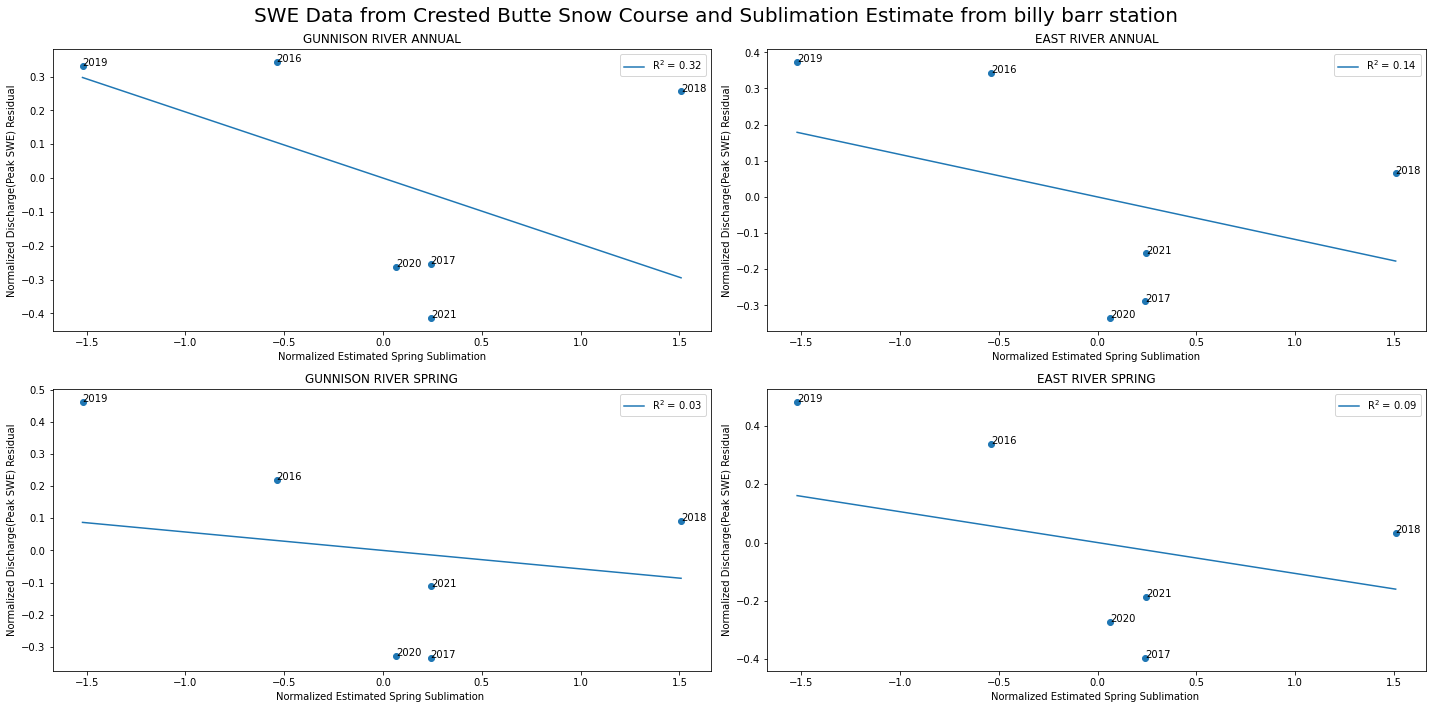

In [261]:
fig, axs = plt.subplots(nrows=2, ncols=2, tight_layout=True, figsize=(20,10))
axs = axs.ravel()
cols = residual_df.columns

residual_df = residual_df
for i,col in enumerate([0,2]):
    # Linear regression
    # Predictor variable for linear regression
    x1 = spring_sublimation_normalized.loc[residual_df[cols[col]].dropna().index].sort_values()
    x2 = spring_sublimation_normalized.loc[residual_df[cols[col+1]].dropna().index].sort_values()
    annual_linregress_stats = stats.linregress(x=x1, y=residual_df[cols[col]].dropna())
    spring_linregress_stats = stats.linregress(x=x2, y=residual_df[cols[col+1]].dropna())    

    # Annual Plots
    y_predicted = annual_linregress_stats[0]*x1+annual_linregress_stats[1]
    axs[i].scatter(spring_sublimation_normalized.loc[residual_df[cols[col]].index], residual_df[cols[col]])
    axs[i].plot(x1,y_predicted, label=f'R$^2$ = {round(annual_linregress_stats[2]**2,2)}')
    axs[i].set_ylabel('Normalized Discharge(Peak SWE) Residual')
    axs[i].set_xlabel('Normalized Estimated Spring Sublimation')
    axs[i].set_title(f"{cols[col].replace('_',' ').upper()}")
    axs[i].legend()

    # Spring Plots
    y_predicted = spring_linregress_stats[0]*x2+spring_linregress_stats[1]
    axs[i+2].scatter(spring_sublimation_normalized.loc[residual_df[cols[col+1]].index], residual_df[cols[col+1]])
    axs[i+2].plot(x2,y_predicted, label=f'R$^2$ = {round(spring_linregress_stats[2]**2,2)}')
    axs[i+2].set_ylabel('Normalized Discharge(Peak SWE) Residual')
    axs[i+2].set_xlabel('Normalized Estimated Spring Sublimation ')
    axs[i+2].set_title(f"{cols[col+1].replace('_',' ').upper()}")
    axs[i+2].legend()

    for j, txt in enumerate(residual_df[cols[i]].index):
        axs[i].annotate(txt, (spring_sublimation_normalized.loc[residual_df[cols[col]].index].iloc[j], residual_df[cols[col]].iloc[j]))
        axs[i+2].annotate(txt, (spring_sublimation_normalized.loc[residual_df[cols[col+1]].index].iloc[j], residual_df[cols[col+1]].iloc[j]))

fig.suptitle('SWE Data from Crested Butte Snow Course and Sublimation Estimate from billy barr station', size=20)
fig.savefig('../../figures/crested_butte_snowcourse_swe_vs_billybarr_sublimation.png')

## Get reanalysis data

In [3]:
# coords = (38.95615768432617, -106.98785400390625)
coords = (37.5,-107.5)
product_codes = ['air','rhum', 'uwnd','vwnd']

In [6]:
def ncep_reanalysis_dynamic_load(product, product_code, start_year, end_year, coords, first_yr_start_date=None, first_yr_end_date=None):
    
    # Connect to FTP server
    print('Connecting to FTP server...')
    ftp = ftplib.FTP('ftp2.psl.noaa.gov') # Connect to NOAA's FTP
    ftp.login() # Anonymous login

    ftp.cwd(f'./Datasets/ncep.reanalysis.dailyavgs/{product}/')

    # Collect files into list
    print('Connected and pulled files...')
    files = ftp.nlst()
    ftp.close()
    print('Closed FTP session...')

    # Separate out files that I'm interested in
    product_files = []
    years = np.arange(start_year, end_year+1,1).astype(str)
    
    for file in files:
        if (product_code in file) & (file[-7:-3] in years):
            product_files.append(file)

    datasets = []
    # Concatenate on year and filter out unncessary values if desired
    for file in product_files:
        print(f'Fetching {file}...')
        # used this as reference: https://towardsdatascience.com/an-efficient-way-to-read-data-from-the-web-directly-into-python-a526a0b4f4cb
        url = f'ftp://ftp2.psl.noaa.gov/Datasets/ncep.reanalysis.dailyavgs/{product}/' + file
        req = urllib.request.Request(url)

        with urllib.request.urlopen(req) as resp:
            ds = xr.open_dataset(io.BytesIO(resp.read()),engine='h5netcdf')
            
            print(f'Filtering {file}...')
            # Transform coordiantes
            ds.coords['lon'] = ds.coords['lon'] - 180
            # Filter to western US
            ds = ds.sel(lat=coords[0], lon=coords[1], method='nearest')
            
            # If provided, remove start year's dates
            if (first_yr_start_date) and (first_yr_end_date) and (f'{start_year}' in file):
                ds = ds.sel(time=slice(first_yr_start_date, first_yr_end_date))
            
            datasets.append(ds)
            print('Done!')
    return xr.concat(datasets, dim='time')

In [7]:
product_codes = ['air','rhum', 'uwnd','vwnd']
for i,code in enumerate(product_codes):
    if i == 0:
        ncep_ds = ncep_reanalysis_dynamic_load('surface', code, 1948, 2021, coords, first_yr_start_date=None, first_yr_end_date=None)
    else:
        tmp = ncep_reanalysis_dynamic_load('surface', code, 1948, 2021, coords, first_yr_start_date=None, first_yr_end_date=None)
        ncep_ds = xr.merge([ncep_ds,tmp])

Connecting to FTP server...
Connected and pulled files...
Closed FTP session...
Fetching air.sig995.1948.nc...
Filtering air.sig995.1948.nc...
Done!
Fetching air.sig995.1949.nc...
Filtering air.sig995.1949.nc...
Done!
Fetching air.sig995.1950.nc...
Filtering air.sig995.1950.nc...
Done!
Fetching air.sig995.1951.nc...
Filtering air.sig995.1951.nc...
Done!
Fetching air.sig995.1952.nc...
Filtering air.sig995.1952.nc...
Done!
Fetching air.sig995.1953.nc...
Filtering air.sig995.1953.nc...
Done!
Fetching air.sig995.1954.nc...
Filtering air.sig995.1954.nc...
Done!
Fetching air.sig995.1955.nc...
Filtering air.sig995.1955.nc...
Done!
Fetching air.sig995.1956.nc...
Filtering air.sig995.1956.nc...
Done!
Fetching air.sig995.1957.nc...
Filtering air.sig995.1957.nc...
Done!
Fetching air.sig995.1958.nc...
Filtering air.sig995.1958.nc...
Done!
Fetching air.sig995.1959.nc...
Filtering air.sig995.1959.nc...
Done!
Fetching air.sig995.1960.nc...
Filtering air.sig995.1960.nc...
Done!
Fetching air.sig995.196

In [8]:
# uwnd = ncep_reanalysis_dynamic_load('surface_gauss', 'uwnd.10m', 1948, 2021, coords, first_yr_start_date=None, first_yr_end_date=None)
# vwnd = ncep_reanalysis_dynamic_load('surface_gauss', 'vwnd.10m', 1948, 2021, coords, first_yr_start_date=None, first_yr_end_date=None)

In [9]:
ncep_ds['wspd'] = np.sqrt(ncep_ds.uwnd**2 + ncep_ds.vwnd**2)

In [107]:
ncep_daily_ds = ncep_ds.to_pandas().groupby(ncep_ds.to_pandas().index.date).mean()
ncep_daily_ds.index = pd.to_datetime(ncep_daily_ds.index)

winter_ncep_ds = ncep_daily_ds.loc[(ncep_daily_ds.index.month<5) | (ncep_daily_ds.index.month==12)]
winter_ncep_ds

,lat,lon,air,rhum,uwnd,vwnd,wspd
1948-01-01,37.5,-107.5,255.489990,66.000000,1.470001,6.369995,6.537411
1948-01-02,37.5,-107.5,256.670013,58.000000,0.500000,4.150009,4.180021
1948-01-03,37.5,-107.5,253.570007,23.750000,-2.619995,2.820007,3.849262
1948-01-04,37.5,-107.5,251.369995,31.250000,-1.300003,4.740005,4.915044
1948-01-05,37.5,-107.5,256.970001,73.740005,5.050003,6.119995,7.934536
...,...,...,...,...,...,...,...
2021-12-27,37.5,-107.5,256.649994,28.750000,1.400001,0.550001,1.504162
2021-12-28,37.5,-107.5,253.849991,20.500000,-1.525000,2.200001,2.676870
2021-12-29,37.5,-107.5,251.199982,0.000000,-5.474999,4.475001,7.071157
2021-12-30,37.5,-107.5,254.749969,35.000000,-2.500000,5.525001,6.064291


In [151]:
net_ncep_winter = calc_net_lw_radiation(temperature=winter_ncep_ds['air']-267.65, 
                      relative_humidity=winter_ncep_ds['rhum'],
                      elevation=2890
                        )

In [161]:
sublimation_ncep_pm = pyet.pm(tmean=winter_ncep_ds['air']-265.15,
        wind=winter_ncep_ds['wspd'],
        rh=winter_ncep_ds['rhum'],
        rn=net_ncep_winter*3600*24/1e6 ,
        elevation=2890)
sublimation_ncep_pm_df = sublimation_ncep_pm.to_frame(name='sublimation_mm')
sublimation_ncep_pm_df['water_year'] =  sublimation_ncep_pm_df.index.year.where(sublimation_ncep_pm_df.index.month < 10, sublimation_ncep_pm_df.index.year + 1)
sublimation_ncep_totals = sublimation_ncep_pm_df['sublimation_mm'].groupby(sublimation_ncep_pm_df['water_year']).sum()
sublimation_ncep_totals.rename = 'sublimation'  

In [360]:
# USGS stream gaging sites
sites = {'Gunnison River':'09114500', 'East River':'09112500'}

# Normalize annual max swe and sublimation estimates
sntl_max_swe_mm_normalized = normalize_data(crested_butte_max_swe_mm)
spring_sublimation_normalized = normalize_data(sublimation_cires_totals)


Text(0.5, 0.98, 'SWE Data from Crested Butte Snow Course')

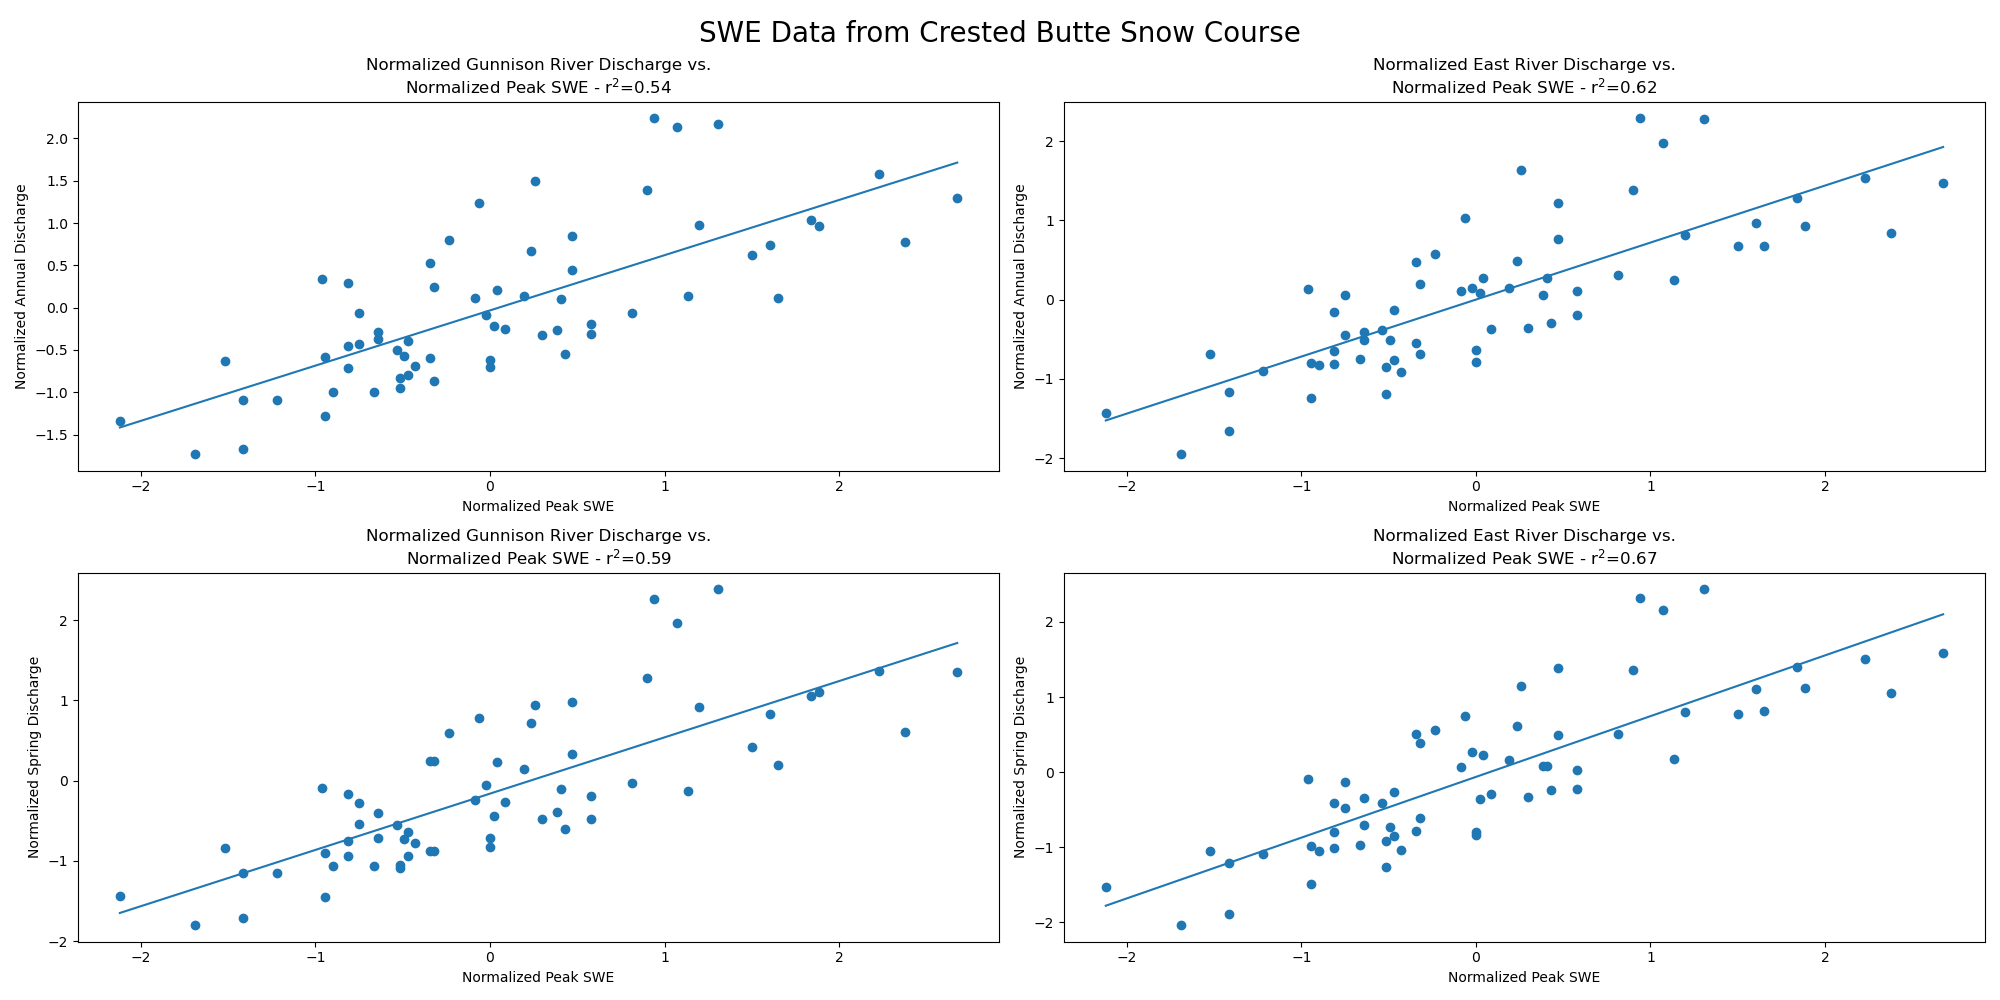

In [361]:
fig, axs = plt.subplots(nrows=2, ncols=2, tight_layout=True, figsize=(20,10))
axs = axs.ravel()
residual_df = pd.DataFrame()

# Unchanged values
idx_mask = crested_butte_max_swe_mm.loc[1948:2014].index
filtered_max_swe = sntl_max_swe_mm_normalized.loc[idx_mask]
x=filtered_max_swe.sort_values()

for i,site in enumerate(sites):
    # Get monthly mean discharge
    monthly_discharge_stats = nwis.get_stats(sites=sites[site], statReportType='monthly', statTypeCd='mean')[0]

    # Compute annual discharge means
    annual_discharge = monthly_discharge_stats['mean_va'].groupby(monthly_discharge_stats['year_nu']).mean()
    annual_discharge_normalized = normalize_data(annual_discharge)

    # Computes spring discharge means
    spring_discharge_stats = monthly_discharge_stats[monthly_discharge_stats['month_nu'].isin([5,6,7])]
    spring_discharge = spring_discharge_stats['mean_va'].groupby(spring_discharge_stats['year_nu']).mean()
    spring_discharge_normalized = normalize_data(spring_discharge)

    # Linear regression
    annual_linregress_stats = stats.linregress(x=filtered_max_swe, y=annual_discharge_normalized.loc[idx_mask])
    spring_linregress_stats = stats.linregress(x=filtered_max_swe, y=spring_discharge_normalized.loc[idx_mask])

    # Annual Plots
    y_predicted = annual_linregress_stats[0]*x+annual_linregress_stats[1]
    residual_df[site+'_annual'] = annual_discharge_normalized.loc[idx_mask] - y_predicted
    axs[i].scatter(filtered_max_swe,annual_discharge_normalized.loc[idx_mask], label='Annual Discharge')
    axs[i].plot(x,y_predicted)
    axs[i].set_ylabel('Normalized Annual Discharge')
    axs[i].set_xlabel('Normalized Peak SWE')
    axs[i].set_title(f'Normalized {list(sites.keys())[i]} Discharge vs.\nNormalized Peak SWE - r$^2$={round(annual_linregress_stats[2]**2,2)}')


    # Spring Plots
    y_predicted = spring_linregress_stats[0]*x+spring_linregress_stats[1]
    residual_df[site+'_spring'] = spring_discharge_normalized.loc[idx_mask] - y_predicted
    axs[i+2].scatter(filtered_max_swe,spring_discharge_normalized.loc[idx_mask], label='Spring Discharge')
    axs[i+2].plot(x,y_predicted)
    axs[i+2].set_ylabel('Normalized Spring Discharge')
    axs[i+2].set_xlabel('Normalized Peak SWE')
    axs[i+2].set_title(f'Normalized {list(sites.keys())[i]} Discharge vs.\nNormalized Peak SWE - r$^2$={round(spring_linregress_stats[2]**2,2)}')

fig.suptitle('SWE Data from Crested Butte Snow Course', size=20)


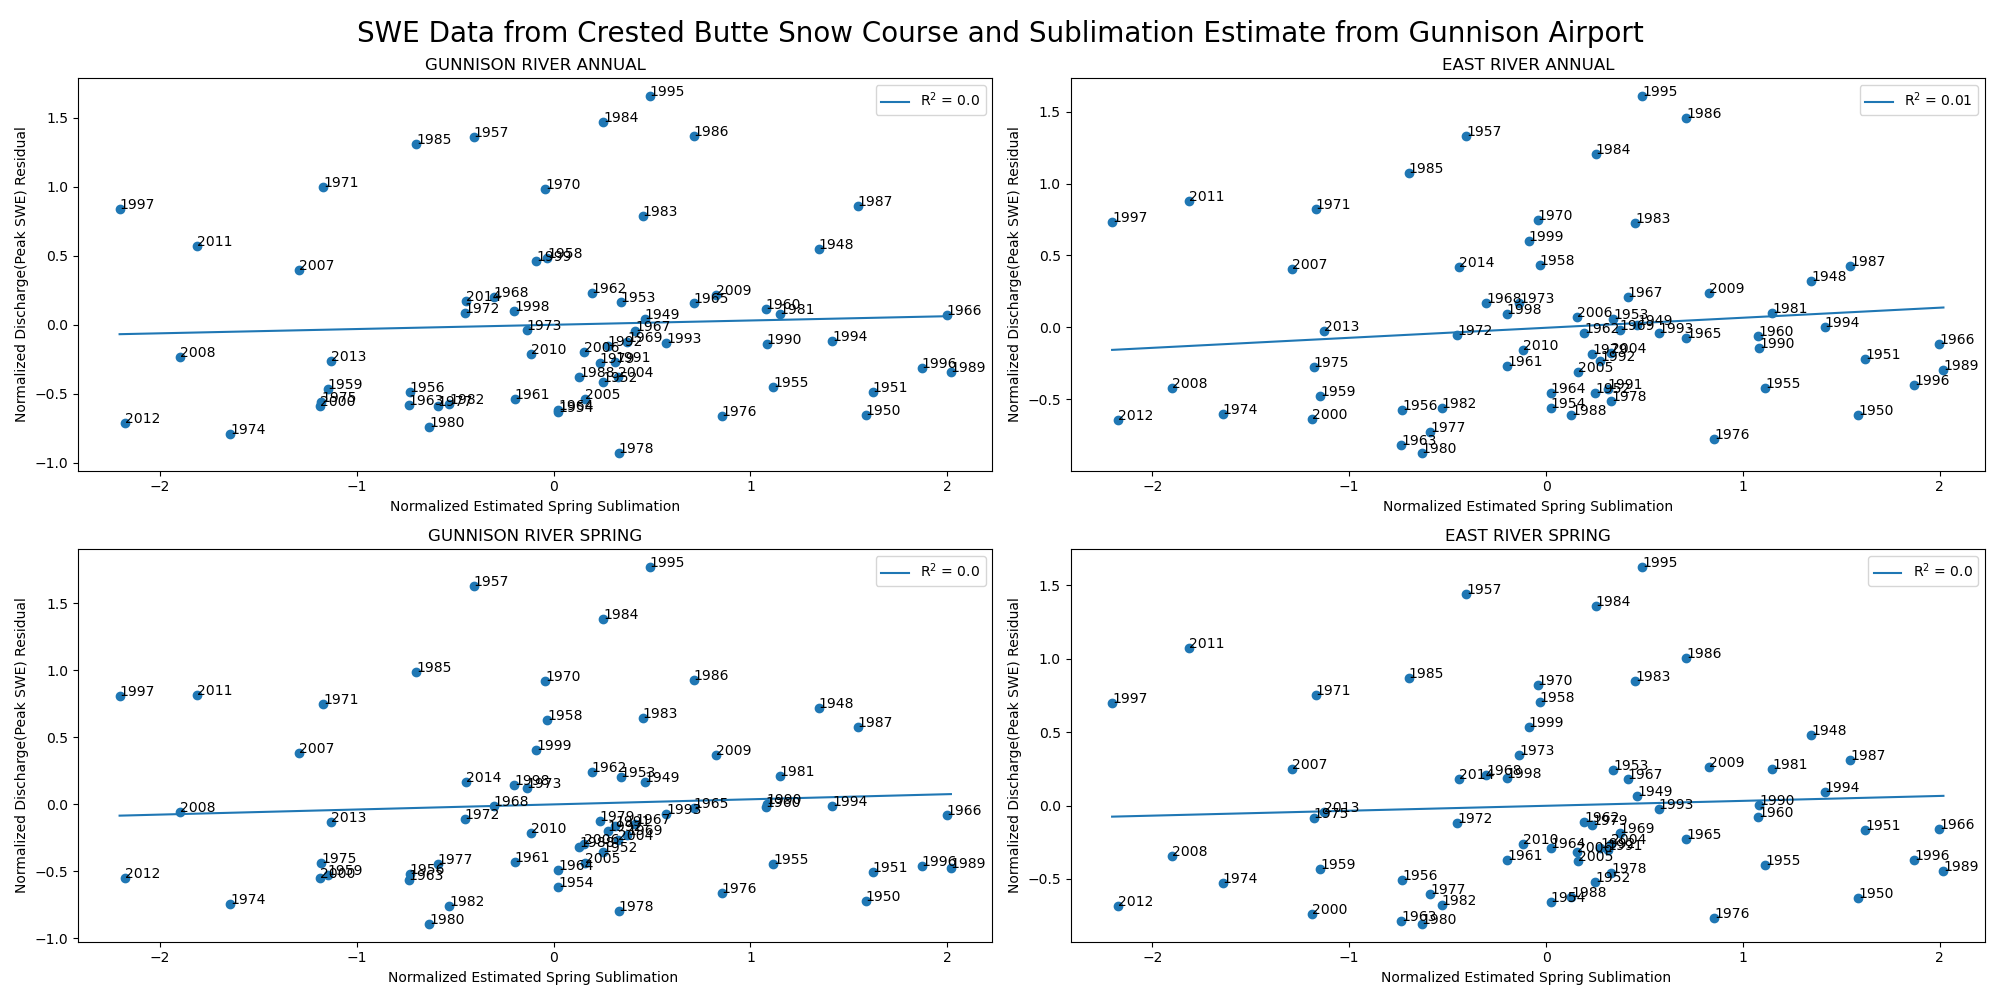

In [362]:
fig, axs = plt.subplots(nrows=2, ncols=2, tight_layout=True, figsize=(20,10))
axs = axs.ravel()
cols = residual_df.columns

for i,col in enumerate([0,2]):
    # Linear regression
    # Predictor variable for linear regression
    x1 = spring_sublimation_normalized.loc[residual_df[cols[col]].dropna().index].sort_values()
    x2 = spring_sublimation_normalized.loc[residual_df[cols[col+1]].dropna().index].sort_values()
    annual_linregress_stats = stats.linregress(x=x1, y=residual_df[cols[col]].dropna())
    spring_linregress_stats = stats.linregress(x=x2, y=residual_df[cols[col+1]].dropna())    

    # Annual Plots
    y_predicted = annual_linregress_stats[0]*x1+annual_linregress_stats[1]
    axs[i].scatter(spring_sublimation_normalized.loc[residual_df[cols[col]].index], residual_df[cols[col]])
    axs[i].plot(x1,y_predicted, label=f'R$^2$ = {round(annual_linregress_stats[2]**2,2)}')
    axs[i].set_ylabel('Normalized Discharge(Peak SWE) Residual')
    axs[i].set_xlabel('Normalized Estimated Spring Sublimation')
    axs[i].set_title(f"{cols[col].replace('_',' ').upper()}")
    axs[i].legend()

    # Spring Plots
    y_predicted = spring_linregress_stats[0]*x2+spring_linregress_stats[1]
    axs[i+2].scatter(spring_sublimation_normalized.loc[residual_df[cols[col+1]].index], residual_df[cols[col+1]])
    axs[i+2].plot(x2,y_predicted, label=f'R$^2$ = {round(spring_linregress_stats[2]**2,2)}')
    axs[i+2].set_ylabel('Normalized Discharge(Peak SWE) Residual')
    axs[i+2].set_xlabel('Normalized Estimated Spring Sublimation ')
    axs[i+2].set_title(f"{cols[col+1].replace('_',' ').upper()}")
    axs[i+2].legend()

    for j, txt in enumerate(residual_df[cols[i]].index):
        axs[i].annotate(txt, (spring_sublimation_normalized.loc[residual_df[cols[col]].index].iloc[j], residual_df[cols[col]].iloc[j]))
        axs[i+2].annotate(txt, (spring_sublimation_normalized.loc[residual_df[cols[col+1]].index].iloc[j], residual_df[cols[col+1]].iloc[j]))

fig.suptitle('SWE Data from Crested Butte Snow Course and Sublimation Estimate from Gunnison Airport', size=20)
fig.savefig('../../figures/crested_butte_snowcourse_swe_vs_kguc_sublimation.png')

In [171]:
def nse(predictions, targets):
    return 1/(2-(1-(np.sum((predictions-targets)**2)/np.sum((targets-np.mean(targets))**2))))

In [177]:
nse(normalize_data(sublimation_ncep_totals.loc[:2021]).loc[1988:2021], normalize_data(sublimation_taylor_totals.loc[1988:2021]))

0.4239093496498079

Try this using the 1910-2021 dataset of daily max min temps

In [217]:
def cires_reanalysis_dynamic_load(product, product_code, start_year, end_year, coords, first_yr_start_date=None, first_yr_end_date=None):
    
    # Connect to FTP server
    print('Connecting to FTP server...')
    ftp = ftplib.FTP('ftp2.psl.noaa.gov') # Connect to NOAA's FTP
    ftp.login() # Anonymous login

    ftp.cwd(f'./Datasets/20thC_ReanV2c/Dailies/gaussian/{product}/')

    # Collect files into list
    print('Connected and pulled files...')
    files = ftp.nlst()
    ftp.close()
    print('Closed FTP session...')

    # Separate out files that I'm interested in
    product_files = []
    years = np.arange(start_year, end_year+1,1).astype(str)
    
    for file in files:
        if (product_code in file) & (file[-7:-3] in years):
            product_files.append(file)

    datasets = []
    # Concatenate on year and filter out unncessary values if desired
    for file in product_files:
        print(f'Fetching {file}...')
        # used this as reference: https://towardsdatascience.com/an-efficient-way-to-read-data-from-the-web-directly-into-python-a526a0b4f4cb
        url = f'ftp://ftp2.psl.noaa.gov/Datasets/20thC_ReanV2c/Dailies/gaussian/{product}/' + file
        req = urllib.request.Request(url)

        with urllib.request.urlopen(req) as resp:
            ds = xr.open_dataset(io.BytesIO(resp.read()),engine='h5netcdf')
            
            print(f'Filtering {file}...')
            # Transform coordiantes
            ds.coords['lon'] = ds.coords['lon'] - 180
            # Filter to western US
            ds = ds.sel(lat=coords[0], lon=coords[1], method='nearest')
            
            # If provided, remove start year's dates
            if (first_yr_start_date) and (first_yr_end_date) and (f'{start_year}' in file):
                ds = ds.sel(time=slice(first_yr_start_date, first_yr_end_date))
            
            datasets.append(ds)
            print('Done!')
    return xr.concat(datasets, dim='time')

In [ ]:
product = 'monolevel'
product_code = 'sbsno'
coords = (38.95615768432617, -106.98785400390625)
sub_df = cires_reanalysis_dynamic_load(product, product_code, 1946, 2015, coords)

daily_sublimation = sub_df.drop_dims('nbnds').to_pandas().groupby(sub_df.drop_dims('nbnds').to_pandas().index.date).mean()/2.837e6 * 24*3600
daily_sublimation.index = pd.to_datetime(daily_sublimation.index)
daily_sublimation['water_year'] = daily_sublimation.index.year.where(daily_sublimation.index.month < 10, daily_sublimation.index.year + 1).astype(int)
winter_cires_df = daily_sublimation.loc[daily_sublimation.index.month < 5 | ((daily_sublimation.index.month == 12) & (daily_sublimation.index.day > 1)) ]
winter_cires_df

<AxesSubplot:xlabel='water_year'>

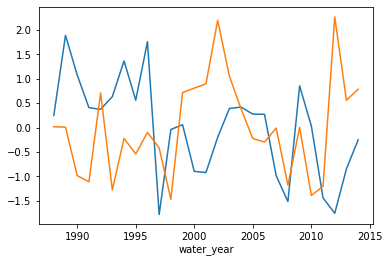

In [233]:
# This does not work very well...
sublimation_cires_totals = winter_cires_df.groupby(winter_cires_df.water_year).sum()['sbsno']
normalize_data(sublimation_cires_totals.loc[1988:2014]).plot()
normalize_data(sublimation_taylor_totals.loc[1988:2014]).plot()